# Depolarization of echo chambers by a random dynamical nudge


To study the effect of RDN, we use an opinion dynamics model.
For a system of $N$ agents, each agent $i$ has an evolving opinion $x_i(t) \in [-\infty, \infty]$.
For a given issue, agent $i$ has a stance with sign $\sigma(x_i)$ and a conviction with strength $|x_i|$.
Strong convictions correspond to one of two extremes.
Agent opinions change based on their interactions with other agents $A_{ij}(t)$,
the strength of social interactions $K > 0$, and the controversialness of the issue $\alpha > 0$
as in Ref \cite{baumann2020modeling}. The opinion dynamics is given by

$$\dot{x}_i= -x_i + K \left(\sum^{N}_{j=1} A_{ij} (t)  \tanh{(\alpha x_j)}\right) + D \sqrt {n}\left(\langle X_{n} \rangle-\langle X \rangle \right) \tag{1}$$

Where $D$ is the RDN strength, $\bar{X}_{n}$ is the mean from a sample (of size $n << N$) of opinions,
and $\langle x \rangle$ is the true mean of all opinions.


## Imports and settings


If in a Colab notebook, this will

1. pull the latest version of `opinion_dynamics` from GitHub
1. add `opinion_dynamics` to path
1. install/upgrade packages
   - upgrade `tqdm` for `tenumerate` function
   - upgrade `tables` for appending to `hdf5` files without throwing an error.
   - `vaex` for large file reading without crashing the session
     - upgrade `IPython` for `vaex` [see #514](https://github.com/vaexio/vaex/issues/514) (upgrading seems to make colab unhappy and won't display Jupyter widgets).
1. mount your Google Drive (by asking for an authorization code)
1. make `.cache` and `.output` in your Google Drive under `My Drive > Colab Notebooks > opdynamics`
1. create symlinks between Colab's temporary local `.cache` and `.output` and the Google Drive folders for persistence

> Note:
>
> 1. After installing packages you **must** restart runtime.
> 1. Creating symlinks will fail when running the cell again. This is expected.


In [1]:
#@title Colab Setup { display-mode: "form" }
import sys

# for persisting data across sessions
connect_gdrive = False #@param {type:"boolean"}
cache_dir = ".cache" #param {allow-input: true}

try:
    from google.colab import drive

    # Clone github repository
    GIT_REPO = "https://github.com/ChrisCurrin/opinion_dynamics.git"
    !rm -rf ./temp
    !git clone --quiet "{GIT_REPO}" ./temp

    # add to path
    sys.path.append('./temp')
    # need latest tqdm version for tenumerate and tables to prevent HDF read error
    !pip install -q --upgrade tqdm tables
    !pip install -q --upgrade vaex IPython

    if connect_gdrive:
        # connect GDrive for retrieving/saving results
        drive.mount('/content/drive')

        # create symlink between a Drive folder and the cache for persistence between sessions
        import os
        try:
            os.makedirs("/content/drive/My Drive/Colab Notebooks/opdynamics/.cache")
            os.makedirs("/content/drive/My Drive/Colab Notebooks/opdynamics/output")
        except IOError:
            pass
        !ln -s "/content/drive/My Drive/Colab Notebooks/opdynamics/.cache" ".cache"
        !ln -s "/content/drive/My Drive/Colab Notebooks/opdynamics/output" "output"

except ModuleNotFoundError:
    print(f"local notebook on {sys.platform}")
    pass

local notebook on darwin


In [2]:
#@title Imports and settings { display-mode: "form" }
%reload_ext autoreload
%autoreload 2

import logging
import itertools
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from tqdm.notebook import tqdm
from matplotlib.colors import LogNorm
from matplotlib.cbook import flatten
from matplotlib.collections import PolyCollection

try:
    import opdynamics.simulation as Simulation
except AttributeError:
    raise RuntimeError("restart runtime")
from opdynamics.socialnetworks import (SocialNetwork, ConnChamber, ContrastChamber, OpenChamber, SampleChamber)
from opdynamics.visualise import (VisSocialNetwork,
                                  show_K_alpha_phase,
                                  show_activity_vs_opinion,
                                  show_jointplot,
                                  show_noise_panel,
                                  show_opinion_grid,
                                  )
from opdynamics.metrics.opinions import calc_distribution_differences, distribution_modality
from opdynamics.visualise import plot_surface_product, plot_surfaces
from opdynamics.utils.distributions import negpowerlaw
from opdynamics.utils.plot_utils import df_multi_mask, move_cbar_label_to_title
from opdynamics.utils.cache import get_cache_dir, set_cache_dir, process_cache_arg
from opdynamics.utils.logging import LoggingContext
from opdynamics.utils.constants import *
from opdynamics.visualise.compat import sns_kdeplot

try:
    os.makedirs("output")
except FileExistsError:
    pass

old_cache_dir, new_dir = set_cache_dir(cache_dir)

np.random.seed(1337)
sns.set_theme(context="notebook", style="ticks",
        rc={
            "pdf.fonttype": 42, # embed font in output
            "svg.fonttype": "none",  # embed font in output
            "figure.facecolor":"white",
            "axes.facecolor": "None",
            "axes.spines.left": True,
            "axes.spines.bottom": True,
            "axes.spines.right": False,
            "axes.spines.top": False,
            }
        )
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"
logging.basicConfig(level=logging.INFO)
logging.getLogger().setLevel(logging.INFO)
logging.getLogger("matplotlib").setLevel(logging.INFO)
logging.getLogger("asyncio").setLevel(logging.WARNING)

# SocialNetworks


We start by showing the rich _object orientated programming_ (OOP) approach to building and running a network that produces echo chambers.

Later, we show how to use `simulation`, which encapsulates a lot of the OOP concepts into a more _functional_ approach.


## Define parameters


| Symbol     | Variable | Keyword   | Meaning                                   | Range ($\mathbb{R}$) |
| ---------- | -------- | --------- | ----------------------------------------- | -------------------- |
| N          | N        | `N`       | Number of agents                          | $>=1$                |
| m          | m        | `m`       | Number of other agents to interact with   | $[1,N)$              |
| $\alpha$   | α        | `alpha`   | controversialness of issue                | $>0$                 |
| $K$        | K        | `K`       | social interaction strength               | $>0$                 |
| $\epsilon$ | ε        | `epsilon` | minimum activity level with another agent | $>0$                 |
| $\gamma$   | Υ        | `gamma`   | power law decay of activity distribution  | $[-\infty, \infty]$  |
| $\beta$    | β        | `beta`    | power law decay of connection probability | $[-\infty, \infty]$  |
| $r$        | r        | `r`       | probability of a mutual interaction       | $[0,1]$              |


In [ ]:
N = 1000
m = 10
alpha = 3
K = 3
epsilon = 1e-2
gamma = 2.1
beta = 3
r = 0.5
# set default activity distribution
activity_distribution = negpowerlaw

## Create SocialNetwork object

An associated `VisSocialNetwork` object is created for quick visualisations.


In [ ]:
sn = SocialNetwork(N, m, K, alpha)
vis = VisSocialNetwork(sn)

## Set activity based on powerlaw distribution

$$F(a) = (\gamma-1) \varepsilon^{\gamma-1} a^{-\gamma} \tag{2}$$


In [ ]:
# @title Show activities for one network { display-mode: "form" }

sn.set_activities(activity_distribution, gamma, epsilon)
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
fig.subplots_adjust(wspace=0.3)
fig.suptitle("t=0")
vis.show_activities(ax=ax[0])
vis.show_activity_vs_opinion(ax=ax[1])

## Social Interactions

$A_{ij}(t)$ is the temporal adjacency matrix, which represents the temporal variability
of interactions \cite{barabasi2005origin}, with $A_{ij}(t)=1$ when there is an input
from agent $j$ to $i$ and $A_{ij}(t)=0$ otherwise. The probabilistic reciprocity
factor $r \in [0, 1]$ determines the chance that a connection is mutually influential,
$(A_{ij}(t)=A_{ji}(t)=1)$. If the interaction is reciprocated, both agents update
their opinions; otherwise, only one of the agents' opinions is updated. For each
instance of the adjacency matrix, interactions are governed by each agent's activity
$a_i \in [\varepsilon, 1]$, the propensity for agent $i$ to interact with $m$ other agents,
and the probability $p_{ij}$ that an active agent $i$ will connect with another agent $j$.
This can lead to the polarization of opinions, where most agents hold a moderate stance on
a binary issue and few, if any, agents have a neutral opinion (Fig. 1(a)).
If active agents have an equal chance of interacting with $m$ other agents regardless of
their stance, then the network can become radicalized, with all agents having the same
stance (Fig. 1(b)).

> a note on implementation
>
> the class `SocialInteraction` (in `opdynamics.dynamics.socialinteractions.py`) handles these dynamics.
>
> it handles calling `get_connection_probabilities` and `get_social_interaction` at each `dt`.
>
> for convenience, arguments for the class and methods are handle by `SocialNetwork.set_social_interactions(beta, r, **kwargs)`.
> This (more or less) calls `SocialInteraction(**kwargs)` and `get_connection_probabilities(beta, **kwargs)` and `get_social_interaction(r)`

### connection probabilities

We define the connection probabilities as a function of the magnitude between two agents' opinions:

$$ p\_{ij} = \frac{|x_i - x_j|^{-\beta}}{\sum_j |x_i - x_j|^{-\beta}} \tag{3}$$

Where $\beta$ is the homophily factor, the tendency for agents with similar opinions to interact with each other:
$\beta = 0$ refers to no interaction preference, and $\beta > 0$ means agents with similar opinions are more likely to interact.
Eq. \ref{conn.eq} is modeled as a power-law decay of connection probabilities with only a small chance for agents with opposite
opinions to interact. Due to most interactions occurring between agents with similar opinions, this can lead to the formation of
echo chambers (Fig. \ref{od1.fig}(d)). We instantiate $p_{ij}$ based on the initial uniform distribution of
opinions $x_i \sim \mathcal{U}(0,1)$ \cite{baumann2020modeling}.

These results held whether the temporal network $A_{ij}(t)$ was determined by an initial $p_{ij}$ or one that was
determined at every time point $p_{ij}(t)$ (`sn.set_social_interactions(beta, r, update_conn=True)`).

### mutual interactions

Every interaction from $j$ to $i$ has a chance $r$ of being reciprocal/mutual. That is, $r=0$ means a directed graph of
interactions, one-way influence, and $r=1$ means an undirected graph of connections and a symmetrical adjacency matrix.

- The matrices are computed at each time step $dt$ and then either
  - stored if `store_all=True` (_warning: can use a lot of RAM!_)
  - thrown away if `store_all=False`; the cumulative interactions are still kept.
- Cumulative adjacency matrix $\sum_{t=0}^T A_{ij}(t)$ can be plotted a number of ways using `vis.show_adjacency_matrix(...)`
  - `clustermap`
  - `heatmap`
  - `mesh`
  Interactions can be sorted using `sort=True` for plotting to identify clusters


In [ ]:
# @title Set social interactions and show connection probabilities

sn.set_social_interactions(beta, r, store_all=True)

fig, ax = vis.show_connection_probabilities(
    "mesh",
    sort=True,
    cmap=sns.cubehelix_palette(light=1, as_cmap=True),
    cbar_kws=dict(pad=0.05),
)
# move label to title
move_cbar_label_to_title(fig)


## Opinion dynamics (without RDN)


In [ ]:
sn.set_dynamics()

## Run and plot results


In [ ]:
dt = 0.01
T = 5
# use Euler for a pretty progress bar, RK45 otherwise.
sn.run_network(dt=dt, t_dur=T, method="Euler")

# some options on how to plot
fig, ax = plt.subplots(nrows=3, sharex="col", sharey="col", figsize=(6, 6))
fig.subplots_adjust(hspace=0.05)
vis.show_opinions(color_code=True, ax=ax[0])  # markers
vis.show_opinions(color_code="line", ax=ax[1], title=False)  # lines
vis.show_opinions(color_code=False, ax=ax[2], title=False)  # agents uniquely coloured
sns.despine(fig)

## Adjacency matrix


In [ ]:
vis.show_adjacency_matrix("mesh", sort=False)
vis.show_adjacency_matrix("clustermap", sort=False)
vis.show_adjacency_matrix("heatmap", sort=True, square=True)

## Save/Load

Given the same parameters, a network can be restored without explicitly calling `run_network`.

A simulation is saved using `sn.save(only_last=True)`. If `only_last` is `False`, the entire duration of the simulation is saved.

If a simulation exists for the network parameters, `sn.load()` restores the saved states and returns `True` (returns `False` otherwise).


In [ ]:
filename = sn.save()
new_ec = SocialNetwork(N, m, K, alpha)
new_ec.set_activities(activity_distribution, gamma, epsilon)
new_ec.set_social_interactions(beta, r, store_all=False)
new_ec.set_dynamics()
loaded = new_ec.load(dt, T)
if not loaded:
    print("run network")
    new_ec.run_network(dt, T)
else:
    print("results loaded")

# Figure 1

> The convenient `Simulation.run_params` static method is used.


In [ ]:
# General params

N = 1000
m = 10
T = 10
epsilon = 1e-2
gamma = 2.1
r = 0.5  # probability of mutual interaction
dt = 0.01
activity_distribution = negpowerlaw

# Specific params for different dynamics
param_set = {
    "neutral": dict(K=3, alpha=0.05, beta=2),
    "radical": dict(K=3, alpha=3, beta=0),
    "polar": dict(K=3, alpha=3, beta=3),
}


## Neutral opinion (not shown)

Low controversialness

- $K = 3$
- $\alpha = 0.05$
- $\beta = 2$


In [ ]:
ec_neutral = Simulation.run_params(
    SocialNetwork,
    N=N,
    m=m,
    **param_set["neutral"],
    activity=activity_distribution,
    epsilon=epsilon,
    gamma=gamma,
    r=r,
    dt=dt,
    T=T,
    plot_opinion=True,
    cache="all"
)


## Polarisation of opinions

Strong social interactions ($K$), controversial issue ($\alpha$), and greater chance of connecting with people with similar opinions ($\beta$)

- $K = 3$
- $\alpha = 3$
- $\beta = 3$


In [ ]:
ec_polar = Simulation.run_params(
    SocialNetwork,
    N=N,
    m=m,
    **param_set["polar"],
    activity=activity_distribution,
    epsilon=epsilon,
    gamma=gamma,
    r=r,
    dt=dt,
    T=T,
    plot_opinion=True,
    cache="all"
)
# plt.savefig("output/fig1a.svg")

In [ ]:
T = 5.0
method = "RK45"
dt = 0.01
cache = "all"

D_range = [0.0, 3.0]
plt.rcParams["figure.dpi"] = 200
fig, axes = plt.subplot_mosaic(
    [
        [
            "time" if i == len(D_range) // 2 else ".",
            f"D panel {i}",
            f"distribution{i}",
            f"recovery{i}",
            f"distribution{i}recover",
        ]
        for i in range(len(D_range))
    ],
    figsize=(8, 8),
)

bins = 100
hist_kwargs = dict(
    title=False,
    vertical=False,
    alpha=0.5,
    bins=bins,
    kde=True,
    kde_kws=dict(bw_adjust=0.5),
    rasterized=True,
)
line_kwargs = dict(lw=0.05)
ylim = (-8, 8)

other_seeds = [1337, 16029, 712406]
time_points = [T, T * 2, T * 3]
x_df = pd.DataFrame(columns=["i", "D", "seed", OPINION_SYMBOL, "t"])
agent_idxs = list(range(N))

for i, D in enumerate(D_range):
    ax_opinion = axes[f"D panel {i}"]
    ax_dist = axes[f"distribution{i}"]
    ax_recovery = axes[f"recovery{i}"]
    ax_dist_recovery = axes[f"distribution{i}recover"]
    for s, seed in enumerate(other_seeds):
        with LoggingContext(logging.INFO):
            print(f"running D={D}")
            sn_polar = Simulation.run_params(
                SampleChamber,
                filename="sn_polar",
                N=N,
                m=m,
                **param_set["polar"],
                activity=activity_distribution,
                epsilon=epsilon,
                gamma=gamma,
                r=r,
                dt=dt,
                T=T,
                plot_opinion=False,
                method=method,
                D=0,
                cache=cache,
                seed=1337,
            )

            vis = VisSocialNetwork(sn_polar)

            if i == 0 and s == 0:
                vis.show_opinions(
                    ax=axes["time"],
                    color_code="line",
                    rasterized=True,
                    title=False,
                    **line_kwargs,
                )
                axes["time"].set(
                    xlim=(0, T),
                    ylim=ylim,
                )
            if s == 0:
                vis.show_opinions_distribution(
                    t=T, ax=ax_dist, color="Green", **hist_kwargs
                )

            sn_polar.filename = f"sn_polar_D{D:.2f}_[{seed}]"
            print(f"running {sn_polar.filename}")

            sn_polar.seed = seed

            if not (cache and sn_polar.load(dt, T * 2)):
                sn_polar.set_dynamics(D=D)
                sn_polar.run_network(dt, T, method=method)
                if cache:
                    sn_polar.save(*process_cache_arg(cache), write_mapping=False)

            vis.show_opinions(
                ax=ax_opinion,
                color_code="line",
                rasterized=True,
                title=False,
                **line_kwargs,
            )

            vis.show_opinions_distribution(ax=ax_dist, **hist_kwargs)

            sn_polar.filename = f"sn_polar_D{D:.2f}_recover[{seed}]"
            # turn off D
            if not (cache and sn_polar.load(dt, T * 3)):
                sn_polar.set_dynamics(D=0)
                sn_polar.run_network(dt, T, method=method)
                if cache:
                    sn_polar.save(*process_cache_arg(cache), write_mapping=False)

            vis.show_opinions(
                ax=ax_recovery,
                color_code="line",
                rasterized=True,
                title=False,
                **line_kwargs,
            )

            vis.show_opinions_distribution(ax=ax_dist_recovery, **hist_kwargs)

            for t in time_points:
                tmp_df = pd.DataFrame(
                    {
                        OPINION_SYMBOL: sn_polar.opinions_at_t(t)[-1],
                        "t": t,
                        "i": sn_polar.agent_idxs,
                        "D": D,
                        "seed": seed,
                    }
                )
                x_df = x_df.append(tmp_df, ignore_index=True)

    sns.despine(ax=ax_dist, left=True)
    sns.despine(ax=ax_opinion, left=True)
    sns.despine(ax=ax_dist_recovery, left=True)
    sns.despine(ax=ax_recovery, left=True)
    # axes[1,i].axvline(x=T, color="k", linestyle="--")
    if i < len(D_range) - 1:
        ax_opinion.set(xlabel="", ylabel="", ylim=ylim, yticklabels=[], xticklabels=[])
        ax_recovery.set(xlabel="", ylabel="", ylim=ylim, yticklabels=[], xticklabels=[])
        ax_dist.set(xlabel="", ylabel="", xlim=ylim)
        ax_dist_recovery.set(xlabel="", ylabel="", xlim=ylim)

    ax_opinion.set_xlim(left=T)
    ax_recovery.set_xlim(left=T * 2)
    ax_opinion.set_title(f"D={D:.0f}", va="top", loc="left")


In [ ]:
with sns.plotting_context("poster", rc={"figure.dpi": 400}):
    g = sns.displot(
        data=x_df,
        x=OPINION_SYMBOL,
        hue="D",
        col="t",
        row="D",
        kind="kde",
        fill=True,
        bw_adjust=0.1,
    )
    g.set(xlim=(-5, 5))


## Radicalisation of opinions

Uniform connection probabilities

- $K = 3$
- $\alpha = 3$
- $\beta = 0$


In [ ]:
ec_radical = Simulation.run_params(
    SocialNetwork,
    N=N,
    m=m,
    **param_set["radical"],
    activity=activity_distribution,
    epsilon=epsilon,
    gamma=gamma,
    r=r,
    dt=dt,
    T=T,
    plot_opinion=True,
    cache="all"
)


_for moderate $\beta$, a polarised network may turn radical._


In [ ]:
T = 20
ec_polar_radical = Simulation.run_params(
    SocialNetwork,
    N=N,
    m=m,
    K=3,
    alpha=3,
    beta=0.6,
    activity=activity_distribution,
    epsilon=epsilon,
    gamma=gamma,
    r=r,
    dt=dt,
    T=T,
    plot_opinion=False,
    cache="all",
)
vis = VisSocialNetwork(ec_polar_radical)
fig, axs = plt.subplots(2, 2, sharex="row", sharey=False)
gs = axs[0, 0].get_gridspec()
# remove the underlying axes
for ax in axs[0, :]:
    ax.remove()
axbig = fig.add_subplot(gs[0, :])
fig.subplots_adjust(hspace=0.3)
vis.show_opinions(color_code="line", subsample=2, lw=1, ax=axbig)
vis.show_opinions_distribution(
    t=5.0, ax=axs[1, 0], kde_kws=dict(bw_adjust=0.1), fill=True, title=f"5"
)
vis.show_opinions_distribution(ax=axs[1, -1], fill=True, title=f"{T}")


## Activity vs Opinion

Polarised param set

- $r = 0.65$


> to reproduce the density in the papers, $10^3$ "opinion states" need to be plotted, with each opinion state consisting of 1000 agents' opinions.


In [ ]:
# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)

# parameters
N = 1000
m = 10
T = 5
activity_distribution = negpowerlaw
epsilon = 1e-2
gamma = 2.1
dt = 0.01
r = 0.65

# how many simulations to run
try:
    from google.colab import drive

    num_states = 1000
except ModuleNotFoundError:
    num_states = 10
# where to save the file
file_name = ".cache/activity_vs_opinion.h5"

# helper array
agent_indices = np.arange(N, dtype=int)

# the efficient HDF format is used for saving and loading DataFrames.
with pd.HDFStore(file_name) as hdf:
    # get keys from the store to know how many simulations have already been saved
    states = hdf.keys()
    states_completed = len(states)
    # we start iterating from states_completed as the `seed` parameter uses `i`
    for i in tqdm(range(states_completed, num_states)):
        sn = Simulation.run_params(
            SocialNetwork,
            N=N,
            m=m,
            **param_set["polar"],
            activity=activity_distribution,
            epsilon=epsilon,
            gamma=gamma,
            r=r,
            dt=dt,
            T=T,
            cache=False,  # don't cache time portion
            seed=i,
        )
        # create dataframe for this iteration
        df = pd.DataFrame({"activity": sn.activities, "opinion": sn.opinions})
        # save to disk for use later
        hdf.append(f"d{i}", df)


# return to previous logging (more or less - we change root level)
logging.getLogger().setLevel(logging_level)

# collect all data into a dataframe
with pd.HDFStore(file_name) as hdf:
    df_ao = pd.concat([hdf.get(key) for key in hdf.keys()])

# plot everything
# (very good idea to rasterize for saving)
fig, ax, cbar = show_activity_vs_opinion(
    df_ao.opinion.values,
    df_ao.activity.values,
    bins=N,
    norm=LogNorm(),
    cmap="icefire",
    cbar_kws=dict(cax=True),
    s=0.1,
    rasterized=True,
)
ax.set_ylim(0, 0.5)
sns.despine()

# clear up some ram
del df_ao


## Nearest Neighbour


In [ ]:
vis = VisSocialNetwork(ec_polar)

levels = 10

fig, ax_joint, ax_marg_x, ax_marg_y = vis.show_nearest_neighbour(
    bw_adjust=0.5,
    color=sns.cubehelix_palette(levels, reverse=True)[levels // 2],
    cmap=sns.cubehelix_palette(levels, reverse=True, as_cmap=True),
    levels=levels,
    shade_lowest=True,
)
lim = (-5, 5)
ax_joint.set_xlim(*lim)
# keep it 'square' (xlim == ylim)
ax_joint.set_ylim(*lim)

## Internal noise


### Dynamic connections


| Symbol      | Keyword | Class (inherits from)        | Meaning                                                      | Range ($\mathbb{R}$) |
| ----------- | ------- | ---------------------------- | ------------------------------------------------------------ | -------------------- |
| $P(-\beta)$ | `p_opp` | `ConnChamber(SocialNetwork)` | Probability of interacting with an agent of opposing opinion | $[0,1]$              |


In [ ]:
# @title Dynamic connections { run: "auto", vertical-output: true }

# polar opinions
N = 1000
m = 10  # number of other agents to interact with
alpha = 3  # controversialness of issue (sigmoidal shape)
K = 3  # social interaction strength
epsilon = 1e-2  # minimum activity level with another agent
gamma = 2.1  # power law distribution param
beta = 3  # power law decay of connection probability
r = 0.5  # probability of a mutual interaction
activity_distribution = negpowerlaw
dt = 0.01
T = 10
seed = 1337
p_opp = 0.5  # @param {type:"slider", min:0, max:1, step:0.05}
with LoggingContext(logging.DEBUG):
    cc = Simulation.run_params(
        ConnChamber,
        N=N,
        m=m,
        K=K,
        alpha=alpha,
        beta=beta,
        activity=activity_distribution,
        epsilon=epsilon,
        gamma=gamma,
        r=r,
        dt=dt,
        T=T,
        p_opp=p_opp,
        seed=seed,
        name=f"p_opp={p_opp}, seed={seed}",
        cache="all",
        method="RK45",
        plot_opinion=False,  # gets plotted better below
    )

with sns.plotting_context():
    vis = VisSocialNetwork(cc)
    fig, ax = plt.subplots(
        2, 2, figsize=(4, 8), gridspec_kw=dict(width_ratios=[1, 0.1])
    )
    vis.show_opinions(ax=ax[0, 0])
    fig.subplots_adjust(wspace=0.1, hspace=0.5)
    vis.show_opinions_distribution(
        ax=ax[0, 1], vertical=True, kde_kws=dict(bw_adjust=0.1)
    )
    vis.show_adjacency_matrix(
        "mesh",
        sort=True,
        cmap=sns.cubehelix_palette(light=1, as_cmap=True),
        cbar_kws=dict(pad=0.05, cax=ax[1, 1]),
        ax=ax[1, 0],
    )
    # vis.show_connection_probabilities("mesh", sort=True,
    #                                   cmap=sns.cubehelix_palette(light=1, as_cmap=True),
    #                                   cbar_kws=dict(pad=0.05, cax=ax[1,1]),
    #                                   ax=ax[1,0])
    # move_cbar_label_to_title(ax[1,1])
    for _ax in ax[0, :]:
        _ax.set_ylim(-5, 5)
    sns.despine()
    sns.despine(ax=ax[0, 1], left=True)
    ax[0, 1].set_ylabel("")
    ax[0, 1].set_yticks([])
    fig.suptitle(f"p_opp={p_opp}")
    fig.set_facecolor("w")


In [ ]:
P_OPP = "$p_{opp}$"
p_opps = np.round(np.arange(0, 1.01, 0.1), 2)
seeds = [10725983, 7988657, 1572039, 15379820, 101, 10001]

kwargs = dict(
    N=1000,
    m=10,
    activity_distribution=negpowerlaw,
    epsilon=1e-2,
    gamma=2.1,
    dt=0.01,
    T=10,
    K=3,
    beta=3,
    alpha=3,
    r=0.5,
)

range_vars = {
    "p_opp": {"range": p_opps, "title": P_OPP},
    "seed": {"range": seeds},
    "beta": {"range": [1, 3], "title": "beta"},
}

set_cache_dir(cache_dir)
with LoggingContext(logging.INFO):
    p_opp_df = Simulation.run_product(
        range_vars,
        cls=ConnChamber,
        cache=True,  # save just end points, not full evolution
        cache_sim="p_opp",
        method="RK45",
        parallel=5,
        **kwargs
    )
p_opp_df

In [ ]:
# some extra processing for nearest neighbours calculation

# run "again" (it's cached) to get the social network objects (cache_sim=False)
with LoggingContext(logging.WARNING):
    sn_arr = Simulation.run_product(
        range_vars,
        cls=ConnChamber,
        cache=True,
        cache_sim=False,  # get list of social network objects if False
        cache_mem=True,
        method="RK45",
        parallel=5,
        **kwargs
    )

nn_df = pd.DataFrame(columns=["opinion", "NN"])
adj_mat_p_opp = {}
for sn in sn_arr:
    p_opp = sn.adj_mat.conn_kwargs["p_opp"]
    nn_df = nn_df.append(
        pd.DataFrame(
            {
                "opinion": sn.opinions,
                "NN": sn.get_nearest_neighbours(),
                "seed": sn._seed,
                "p_opp": p_opp,
            }
        )
    )
    if p_opp in adj_mat_p_opp:
        adj_mat_p_opp[p_opp] += sn.adj_mat.accumulator
    else:
        adj_mat_p_opp[p_opp] = sn.adj_mat.accumulator

# get maximum value in cumulative adjacency matrix
max_accum_val = 0

for key, val in adj_mat_p_opp.items():
    max_accum_val = max(max_accum_val, np.max(val))

nn_df["seed"] = nn_df["seed"].astype(int)
nn_df

In [ ]:
def plot_p_opp_density(
    p_opp_df, run_p_opps=None, betas=None, axes=None, save=False, subplot_adjust=None
):
    if run_p_opps is None:
        run_p_opps = sorted(p_opp_df["p_opp"].unique())

    if axes is None:
        fig, axes = plt.subplots(
            len(run_p_opps), figsize=(5, 7), sharex=False, sharey=True
        )
    else:
        fig = axes[0].figure

    bw_adjust = 0.5

    pd_p_opp = p_opp_df.to_pandas_df().rename(
        columns={"p_opp": P_OPP, "opinion": OPINION_SYMBOL}
    )

    if betas is None:
        betas = p_opp_df["beta"].unique()
    else:
        pd_p_opp = pd_p_opp[pd_p_opp["beta"].isin(betas)]

    if len(betas) > 1:
        hue = "beta"
        hue_order = betas
    else:
        hue = "seed"
        hue_order = sorted(p_opp_df["seed"].unique())

    # more colors for blending
    pal = sns.color_palette("icefire", n_colors=len(run_p_opps) * 2 + 1)

    for i, p_opp in enumerate(run_p_opps):
        sns.kdeplot(
            data=pd_p_opp[pd_p_opp[P_OPP] == p_opp],
            x=OPINION_SYMBOL,
            hue=hue,
            hue_order=hue_order,
            ax=axes[i],
            palette=sns.blend_palette(
                [pal[i * 2], pal[i * 2 + 1]], n_colors=len(hue_order), input="hex"
            ),
            bw_adjust=bw_adjust,
            clip_on=False,
            fill=True,
            alpha=0.5,
            linewidth=1.5,
            edgecolor="w",
            legend=False,
            zorder=100,
        )
        axes[i].set(ylabel="", yticks=[], yticklabels=[], xlim=(-5, 5))

        axes[i].text(
            0,
            0.2,
            f"{p_opp}",
            fontweight="bold",
            color=pal[i * 2],
            ha="right",
            va="center",
            transform=axes[i].transAxes,
        )

        if i < len(run_p_opps) - 1:
            axes[i].set(xticks=[], xlabel="")
    if subplot_adjust:
        fig.subplots_adjust(hspace=subplot_adjust)
    # fig.subplots_adjust(hspace=0.01)
    for ax in axes:
        sns.despine(ax=ax, left=True, bottom=True)

    axes[0].set(xlim=(-5, 5))
    if save:
        fig.savefig(f"output/p_opp_{save}", facecolor="w", transparent=True)


with sns.plotting_context("poster"):
    plt.rcParams["axes.facecolor"] = "None"
    plot_p_opp_density(
        p_opp_df,
        run_p_opps=[0.0, 0.2, 0.5, 0.8, 1.0],
        betas=[3],
        save=False,
        subplot_adjust=-0.25,
    )
    # plot_p_opp_density(p_opp_df, run_p_opps=[0.0, 0.2, 0.5, 0.8, 1.0], save="beta", subplot_adjust=-.25)


In [ ]:
# same as above, but add in nearest neighbours
from opdynamics.visualise.dense import show_matrix

with sns.plotting_context("poster"):
    plt.rcParams["axes.facecolor"] = "None"

    run_p_opps = sorted(p_opp_df["p_opp"].unique())
    run_p_opps = [0.0, 0.2, 0.5, 0.8, 1.0]
    fig, axes = plt.subplots(
        len(run_p_opps),
        2,
        figsize=(5, 8),
        gridspec_kw={"width_ratios": [1, 0.5]},
        sharex=False,
        sharey="col",
    )
    fig.suptitle(P_OPP)
    bw_adjust = 0.5

    pd_p_opp = nn_df.rename(
        columns={
            "p_opp": P_OPP,
            "opinion": OPINION_SYMBOL,
            "NN": MEAN_NEAREST_NEIGHBOUR,
        }
    )

    # more colors for blending
    pal = sns.color_palette("icefire", n_colors=len(run_p_opps))

    for i, p_opp in enumerate(run_p_opps):
        iter_df = pd_p_opp[(pd_p_opp[P_OPP] == p_opp) & (pd_p_opp["seed"].isin(seeds))]
        sns.kdeplot(
            data=iter_df,
            x=OPINION_SYMBOL,
            ax=axes[i, 0],
            color=pal[i],
            bw_adjust=bw_adjust,
            clip_on=False,
            fill=True,
            alpha=1,
            linewidth=2,
            edgecolor="w",
            legend=False,
            zorder=100,
        )

        axes[i, 0].set(ylabel="", yticks=[], yticklabels=[], xlim=(-5, 5))

        axes[i, 0].text(
            0,
            0.2,
            f"{p_opp}",
            fontweight="bold",
            color=pal[i],
            ha="right",
            va="center",
            transform=axes[i, 0].transAxes,
            zorder=100,
        )

        # show_matrix(adj_mat_p_opp[p_opp], label="", sort=True,
        #             vmin=1, vmax=max_accum_val, map="heatmap",
        #             ax=axes[i,1],
        #             cmap=sns.cubehelix_palette(light=1, as_cmap=True),
        #             # cbar_kws=dict(cax=False),
        #             title=False
        #             )
        # axes[i,1].set(ylabel="", yticks=[], yticklabels=[], xlabel="", xticks=[])

        show_jointplot(
            x=iter_df[OPINION_SYMBOL],
            y=iter_df[MEAN_NEAREST_NEIGHBOUR],
            ax=axes[i, 1],
            bw=bw_adjust,  # uses old kde syntax
            shade_lowest=False,
            cmap=sns.light_palette(pal[i], as_cmap=True),
        )
        axes[i, 1].set(xlim=(-5, 5), ylim=(-5, 5))

        if i < len(run_p_opps) - 1:
            axes[i, 0].set(xticks=[], xlabel="")
            axes[i, 1].set(ylabel="", yticks=[], yticklabels=[], xlabel="", xticks=[])
        else:
            axes[i, 1].set(xlabel=OPINION_SYMBOL, ylabel=MEAN_NEAREST_NEIGHBOUR)

    fig.subplots_adjust(hspace=-0.4, wspace=0.3)
    # fig.subplots_adjust(hspace=0.0)
    sns.despine(left=True, bottom=True)

    fig.savefig("output/p_opp_nn.svg", facecolor="w", transparent=True)

### Contrastive noise

Noise comes from exposing each agent to a random other agent, $x_k$, independent of $\beta$.

Either

1. Contrast own opinion with another
   $\dot{x}_i = K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha_1 x_j)  + D (\tanh(\alpha_2 (x_i - x_k)))$
1. Show another agent's opinion
   $\dot{x}_i = K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha_1 x_j)  + D (\tanh(\alpha_2 (x_k)))$

| Symbol     | Keyword   | Class (inherits from)                  | Meaning                                                |
| ---------- | --------- | -------------------------------------- | ------------------------------------------------------ |
| $x_k$      | `k_steps` | `ConstrastChamber(NoisySocialNetwork)` | Another agent chosen every $k$ time steps.             |
| $\alpha_2$ | `alpha_2` | `ConstrastChamber(NoisySocialNetwork)` | Scaling of agent's opinion (or difference of opinions) |


#### Params vs noise


In [ ]:
kwargs = dict(
    N=1000,
    m=10,
    T=10,
    epsilon=1e-2,
    gamma=2.1,
    dt=0.01,
    K=3,
    beta=3,
    alpha=3,
    r=0.5,
    cls=ContrastChamber,
    noise_start=0,
)

D_step = 0.1
D_range = np.round(np.arange(0.0, 0.5 + D_step, D_step), 3)

parameters = {
    "D": {
        "range": D_range,
        "title": "D",
    },
    "k_steps": {
        "range": [1, 10, 100],
        "title": "k",
    },
    "alpha_2": {
        "range": [0.01, 0.1, 1, 10],
        "title": "$\alpha_2$",
    },
}
with LoggingContext(logging.WARNING):

    df = Simulation.run_product(parameters, cache=True, cache_sim="contrast", **kwargs)
    df

In [ ]:
grid_kwargs = dict(sharex=False, sharey=False, margin_titles=True, legend_out=True)
kde_kwargs = dict(bw_adjust=0.01)
g = show_opinion_grid(
    df, ["alpha_2", "D", "k_steps"], grid_kwargs=grid_kwargs, kde_kwargs=kde_kwargs
)
g.add_legend(fontsize="large")


# NoisySocialNetwork


Add noise to the system

$\dot{x}_i= -x_i + K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha x_j)  + D [\rm nudge]$

| Symbol | Keyword | Class (inherits from)               | Meaning                 | Range ($\mathbb{R}$) |
| ------ | ------- | ----------------------------------- | ----------------------- | -------------------- |
| $D$    | `D`     | `NoisySocialNetwork(SocialNetwork)` | Strength of noise/nudge | $>=0$                |


## Open system (external noise)

$\dot{x}_i = -x_i + K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha x_j)+ D \cdot \xi (t)$

| Symbol      | Class (inherits from)             | Meaning                                                        |
| ----------- | --------------------------------- | -------------------------------------------------------------- |
| $\xi(t)$    | `OpenChamber(NoisySocialNetwork)` | [Wiener process](https://en.wikipedia.org/wiki/Wiener_process) |
| $\dot{\xi}$ | `OpenChamber(NoisySocialNetwork)` | Derivative $\mathcal{N}(0,\sqrt{dt})$                          |


In [ ]:
#@title Nudge strength ($D$)
%matplotlib inline

kwargs = dict(N=1000,
              m=10,
              T=5,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.01,
              K=3,
              beta=3,
              alpha=3,
              r=0.5,
              cls=OpenChamber
             )

D_range = np.round([0.0, 0.5, 1, 2, 3, 4, 5], 1)

with LoggingContext(logging.INFO):
    df_open = Simulation.run_product({'D':{'range':D_range}}, 
                                    plot_opinion=True, 
                                    cache=True, 
                                    cache_sim="open_chamber", 
                                    cache_mem=True, 
                                    parallel=True, 
                                    **kwargs)
fig = plt.gcf()
fig.subplots_adjust(hspace=-0.5)
for ax in fig.axes:
    ax.set_facecolor("None")
    sns.despine(ax=ax, bottom=True, left=True)
    ax.tick_params(bottom=False, left=False, labelleft=False)
# fig.savefig("output/noise.svg")
df_open

In [ ]:
# @title Check `dt`

# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.INFO)
kwargs = dict(
    N=1000,
    m=10,
    T=1,
    epsilon=1e-2,
    gamma=2.1,
    dt=0.001,
    K=2,
    beta=1,
    alpha=3,
    r=0.65,
    cls=OpenChamber,
)
product_vars = {
    "D": {
        "range": [0, 1],
    },
    "dt": {"range": np.round(np.arange(0.001, 0.01 + 0.001, 0.001), 4)},
}
df_open_dt = Simulation.run_product(
    product_vars, parallel=True, plot_opinion=True, cache_sim="var_dt", **kwargs
)
sns.displot(data=df_open_dt.to_pandas_df(), x="opinion", col="D", hue="dt")

logging.getLogger().setLevel(logging_level)

In [ ]:
# @title α, β

kwargs = dict(
    N=1000,
    m=10,
    T=10,
    epsilon=1e-2,
    gamma=2.1,
    dt=0.01,
    K=2,
    beta=1,
    alpha=3,
    r=0.65,
    cls=OpenChamber,
)

D_range = np.round(np.arange(0.0, 1.1, 0.1), 1)

parameters = {
    "D": {
        "range": D_range,
    },
    "beta": {
        "range": [0, 1, 2, 3],
        "title": "$\\beta$",
    },
    "alpha": {
        "range": [0.001, 1, 2, 3],
        "title": "$\\alpha$",
    },
}
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)

df = Simulation.run_product(parameters, **kwargs)

logging.getLogger().setLevel(logging_level)

with sns.plotting_context("talk"):
    max_range = max([other["range"] for other in parameters.values()], key=len)
    fig, ax = plt.subplots(
        len(parameters), len(max_range), sharey=True, sharex=True, squeeze=False
    )
    fig.subplots_adjust(hspace=0.8)
    for i, (key, other) in enumerate(parameters.items()):
        show_noise_panel(df, key, kde_kwargs=dict(bw_adjust=0.1, cut=2), ax=ax[i])
        for _ax in ax[i]:
            _ax.set_title(f"{other['title']}={_ax.get_title()}")
            _ax.set_xlabel("")
            _ax.set(xlim=(-5, 5), ylim=(0, 1))

    sns.despine(fig=fig)
    for _ax in ax[-1]:
        _ax.set_xlabel(math_fix(f"${OPINION_SYMBOL}$"))
    fig.savefig(f"output/{list(parameters.keys())}_grid.svg")


### Delayed noise


In [ ]:
# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
kwargs = dict(
    N=1000,
    m=10,
    activity_distribution=negpowerlaw,
    epsilon=1e-2,
    gamma=2.1,
    dt=0.01,
    K=3,
    beta=3,
    alpha=3,
    r=0.65,
    cls=OpenChamber,
)
D = 0.5

noise_start = 10.0
noise_length = 10.0
recovery = 10.0
num = 1
interval = 0
nsn = Simulation.run_periodic_noise(
    noise_start,
    noise_length,
    recovery,
    interval=interval,
    num=num,
    **kwargs,
    D=D,
    plot_opinion=True
)
# fig = plt.gcf()
# fig.savefig("output/delayed_noise.svg")
logging.getLogger().setLevel(logging_level)


## Generate figure 1


In [ ]:
### Generate figure 1
from opdynamics.utils.plot_utils import move_cbar_label_to_title

run_p_opps = [0.0, 0.2, 0.5, 0.8, 1.0]
D_vals = [0.0, 0.5, 1.0, 3.0]
sns.reset_defaults()

with sns.plotting_context("paper"):
    plt.rcParams["axes.facecolor"] = "None"
    # create figure and grid
    fig = plt.figure(figsize=(7.2, 5), dpi=400)
    gs = gridspec.GridSpec(
        nrows=3,
        ncols=2,
        wspace=0.3,
        hspace=0.9,
        left=0.18,
        right=0.97,
        bottom=0.15,
        height_ratios=[1, 1.618, 1],
        width_ratios=[2, 1],
    )
    gs_traces = gridspec.GridSpecFromSubplotSpec(
        1, 2, subplot_spec=gs[0, 0], hspace=0.2, wspace=0.2
    )

    gs_nn = gridspec.GridSpecFromSubplotSpec(
        2,
        4,
        subplot_spec=gs[1, 0],
        width_ratios=[1, 0.1, 1, 0.1],
        height_ratios=[0.1, 1],
        wspace=0.2,
        hspace=0.2,
    )

    gs_pop = gridspec.GridSpecFromSubplotSpec(
        len(run_p_opps), 1, subplot_spec=gs[:-1, -1], wspace=0.1, hspace=-0.25
    )

    num_D = len(D_vals)
    gs_d = gridspec.GridSpecFromSubplotSpec(
        1,
        1 + num_D,
        subplot_spec=gs[-1, :],
        hspace=0.2,
        width_ratios=[1] + [0.5] * num_D,
    )

    # create axes
    ax_trace_1 = fig.add_subplot(gs_traces[0, 0])
    ax_trace_2 = fig.add_subplot(gs_traces[0, 1])
    ax_joint = fig.add_subplot(gs_nn[1, 0])
    ax_marg_x = fig.add_subplot(gs_nn[0, 0], sharex=ax_joint)
    ax_marg_y = fig.add_subplot(gs_nn[1, 1], sharey=ax_joint)

    ax_joint_rad = fig.add_subplot(gs_nn[1, -2])
    ax_marg_x_rad = fig.add_subplot(gs_nn[0, -2], sharex=ax_joint_rad)
    ax_marg_y_rad = fig.add_subplot(gs_nn[1, -1], sharey=ax_joint_rad)

    popp_axes = [fig.add_subplot(gs_pop[i, 0]) for i in range(len(run_p_opps))]

    ax_d_trace = fig.add_subplot(gs_d[0, 0])
    ax_d = []
    for i in range(num_D):
        ax_d.append(
            fig.add_subplot(
                gs_d[0, 1 + i],
                sharey=ax_d[0] if i > 0 else None,
                sharex=ax_d[0] if i > 0 else None,
            )
        )

    # Make the grid look nice
    sns.despine(fig)
    sns.despine(ax=ax_trace_1, right=False)  # keep right border
    sns.despine(ax=ax_trace_2, right=False)  # keep right border
    ax_trace_1.spines["right"].set_color("purple")
    ax_trace_2.spines["right"].set_color("red")
    sns.despine(ax=ax_marg_x, left=True)
    sns.despine(ax=ax_marg_y, bottom=True)
    sns.despine(ax=ax_marg_x_rad, left=True)
    sns.despine(ax=ax_marg_y_rad, bottom=True)
    # polarised opinions trace
    vis = VisSocialNetwork(ec_polar)
    trace_kwargs = dict(color_code="line", subsample=2, lw=0.5, rasterized=True)
    vis.show_opinions(ax=ax_trace_1, title="Polarized", **trace_kwargs)
    # nearest neighbour
    show_jointplot(
        ec_polar.opinions,
        ec_polar.get_nearest_neighbours(),
        ax=(ax_joint, ax_marg_x, ax_marg_y),
        marginal_kws=dict(bw_adjust=0.5),
    )

    # radicalised opinions trace
    vis_radical = VisSocialNetwork(ec_radical)
    vis_radical.show_opinions(ax=ax_trace_2, title="Radicalized", **trace_kwargs)
    show_jointplot(
        ec_radical.opinions,
        ec_radical.get_nearest_neighbours(),
        ax=(ax_joint_rad, ax_marg_x_rad, ax_marg_y_rad),
        cmap="Reds",
        marginal_kws=dict(color="red", bw_adjust=0.5),
    )
    ax_joint_rad.set_facecolor("#ffeee6")

    plot_p_opp_density(
        p_opp_df,
        run_p_opps=run_p_opps,
        betas=[3],
        axes=popp_axes,
        save="indv",
    )

    # plot D
    D_colors = sns.color_palette("Greys", n_colors=num_D)

    kwargs = dict(
        N=1000,
        m=10,
        T=5,
        epsilon=1e-2,
        gamma=2.1,
        dt=0.01,
        K=3,
        beta=3,
        alpha=3,
        r=0.5,
    )

    chosen_D = 1.0
    sn_D = Simulation.run_params(
        cls=OpenChamber,
        D=chosen_D,
        cache="all",
        **kwargs,
    )
    vis_sn_D = VisSocialNetwork(sn_D)
    vis_sn_D.show_opinions(ax=ax_d_trace, **trace_kwargs)
    sns.despine(ax=ax_d_trace, top=False, right=False)

    d_color = D_colors[D_vals.index(chosen_D)]
    ax_d_trace.spines["top"].set_color(d_color)
    ax_d_trace.spines["right"].set_color(d_color)
    ax_d_trace.spines["top"].set_linewidth(2)
    ax_d_trace.set_title(
        "random dynamical nudge",
        color=d_color,
        # weight="bold"
    )

    for i, ax in enumerate(ax_d):
        df_d = (
            df_open[df_open["D"] == D_vals[i]]
            .to_pandas_df()
            .rename(columns={"opinion": OPINION_SYMBOL})
        )
        sns.kdeplot(
            data=df_d,
            x=OPINION_SYMBOL,
            color=D_colors[i],
            ax=ax,
            shade=True,
            bw_adjust=0.5,
        )

        ax.set(yticks=[], ylabel="")
        pop_dist = distribution_modality(df_d[OPINION_SYMBOL].values)
        y_max = ax.get_ylim()[1]
        ax.annotate(
            f"{pop_dist:.2f}",
            xy=(0, y_max),
            xytext=(0, y_max * 1.05),
            arrowprops=dict(
                arrowstyle=f"-[,widthB={pop_dist}", color="k", alpha=0.7, lw=0.5
            ),
            alpha=0.8,
            fontsize="x-small",
            va="bottom",
            ha="center",
        )

        ax.annotate(
            PEAK_DISTANCE,
            xy=(0.5, 1),
            xycoords="axes fraction",
            va="bottom",
            ha="center",
            fontsize="small",
        )
        ax.set_title(
            f"{D_vals[i]:.1f}",
            color=D_colors[i],
            # fontsize="large",
            loc="left",
            va="top",
            weight="bold",
        )
        sns.despine(ax=ax, left=True)
    # cleaning
    ax_trace_1.set(xticks=[0, 5, 10], xlim=(0, 10))
    ax_trace_2.set(xticks=[0, 5, 10], xlim=(0, 10), ylabel="", yticklabels=[])

    for _ax_jnt in [ax_joint, ax_joint_rad]:
        _ax_jnt.set_xlim(-5, 5)
        _ax_jnt.set_ylim(-5, 5)
        _ax_jnt.set_xlabel(OPINION_SYMBOL)
        _ax_jnt.set_ylabel(MEAN_NEAREST_NEIGHBOUR)

    ax_joint_rad.set(yticklabels=[], ylabel="")

    for _ax in popp_axes:
        sns.despine(ax=_ax, left=True, bottom=True)

    ax_d[0].set_xlim(-5, 5)

    for letter, _ax in zip(
        string.ascii_lowercase,
        [ax_trace_1, ax_marg_x, ax_trace_2, ax_marg_x_rad, popp_axes[0], ax_d_trace],
    ):
        _ax.annotate(
            f"{letter}",
            xy=(0, 1),
            xycoords="axes fraction",
            xytext=(-27, 5),
            textcoords="offset points",
            fontsize="x-large",
            weight="bold",
            va="bottom",
            ha="right",
        )
    # reduce space between axes labels and axes
    # for _ax in flatten(fig.axes):
    #     _ax.yaxis.labelpad = 0
    #     _ax.xaxis.labelpad = 0

    fig.savefig("output/fig1.svg")


## SampleChamber

The Central Limit Theorem states...

> Sample means are normally distributed.

> The mean of sample means approximates the true mean of the population.


In [ ]:
# title Set up polarised opinions { display-mode: "form" }
kwargs = dict(
    N=1000,
    m=10,
    T=5,
    epsilon=1e-2,
    gamma=2.1,
    r=0.5,  # probability of mutual interaction
    dt=0.01,
    K=3,
    alpha=3,
    beta=3,
    activity_distribution=negpowerlaw,
    plot_opinion=True,
    cache="all",
    name="fig2_examples",
)
with LoggingContext(logging.INFO):
    sn_polar = Simulation.run_params(SocialNetwork, **kwargs)

    chosen_D = 3.0

    sn_D_n1 = Simulation.run_params(
        cls=SampleChamber,
        D=chosen_D,
        num_samples=1,
        **kwargs,
    )

    sn_D_nN = Simulation.run_params(
        cls=SampleChamber,
        D=chosen_D,
        **kwargs,
    )

In [ ]:
# title Check sample size and number of samples { run: "auto", display-mode: "form" }

sample_size = 30  # @param {type:"slider", min:1, max:1000, step:1}
num_samples = 1000  # @param {type:"slider", min:1, max:1000, step:1}


with sns.axes_style("ticks"):
    with sns.plotting_context("paper", rc={"figure.dpi": 400}):
        fig, axes = plt.subplots(
            nrows=3,
            ncols=3,
            figsize=(7.2, 5),
            gridspec_kw={"width_ratios": [1, 0.4, 0.4], "height_ratios": [1, 0.4, 0.4]},
            sharey=True,
            sharex="col",
        )
        fig.subplots_adjust(hspace=0.3)
        # fig.subplots_adjust(wspace=0.05)
        VisSocialNetwork(sn_polar).show_opinions(
            "line", ax=axes[0, 0], title="", rasterized=True
        )
        sns.kdeplot(
            y=sn_polar.opinions,
            ax=axes[0, 1],
            shade=True,
            bw_adjust=0.5,
            color="Purple",
        )
        sample_means = sn_polar.get_sample_means(sample_size, num_samples)
        mu = np.mean(sample_means)

        sns.histplot(y=sample_means, kde=True, ax=axes[0, 2])

        ax = axes[0, -1]
        ax.annotate(
            f"$ \langle \langle X_{{{sample_size}}} \\rangle \\rangle =$ {mu:.3f}",
            xy=(ax.get_xlim()[1], mu),
            xytext=(-5, 5),
            textcoords="offset points",
            ha="left",
            va="bottom",
            fontsize="x-small",
            color="gray",
            # arrowprops=dict(arrowstyle='-|>'),
        )
        ax.axhline(y=mu, color="gray", linestyle="--", lw=1)

        ax = axes[0, -2]
        true_mu = np.mean(sn_polar.opinions)
        ax.annotate(
            f"$\langle X \\rangle =$ {true_mu:.3f}",
            xy=(ax.get_xlim()[1], true_mu),
            xytext=(-5, 0),
            textcoords="offset points",
            ha="right",
            va="bottom",
            fontsize="x-small",
            # arrowprops=dict(arrowstyle='-|>'),
            zorder=100,
            clip_on=False,
            color="gray",
        )
        ax.axhline(y=true_mu, color="gray", linestyle="-", lw=1)

        axes[0, -2].set_title(f"P({OPINION_SYMBOL})")
        axes[0, -1].set_title(f"P($\langle X_{{{sample_size}}} \\rangle$)")
        # ax.set_ylabel(f"$P(\overline{{X}}_n)$\n[# samples = {num_samples}]")
        # ax.set(yticks=False,)
        sns.despine(ax=axes[0, 0], right=False)
        axes[0, 0].spines["right"].set_color("Purple")
        axes[0, 0].set_xlabel("")

        for ax in axes[0, -2:]:
            sns.despine(ax=ax, left=True, bottom=True)
            ax.set(xticks=[], xlabel="")
        axes[0, -2].spines["right"].set_visible(True)
        axes[0, -2].spines["right"].set_color("#abbdd9")
        axes[0, -2].spines["right"].set_linestyle(":")
        axes[0, -2].spines["right"].set_linewidth(0.8)

        # plot with noise
        ax_d_n1 = axes[1, 0]
        ax_d_nN = axes[2, 0]
        VisSocialNetwork(sn_D_n1).show_opinions(
            "line", ax=ax_d_n1, title="", rasterized=True
        )
        VisSocialNetwork(sn_D_nN).show_opinions(
            "line", ax=ax_d_nN, title="", rasterized=True
        )
        try:
            d_color = D_colors[D_vals.index(chosen_D)]
        except:
            d_color = "grey"
        ax_d_n1.set_xlabel("")

        sns.kdeplot(
            y=sn_D_n1.opinions, ax=axes[1, 1], shade=True, bw_adjust=0.5, color=d_color
        )
        sns.kdeplot(
            y=sn_D_nN.opinions, ax=axes[2, 1], shade=True, bw_adjust=0.5, color=d_color
        )
        ax_d_n1.spines["top"].set_color(d_color)
        ax_d_n1.spines["right"].set_color(d_color)
        ax_d_n1.spines["top"].set_linewidth(2)
        ax_d_n1.set_title(
            "$\\mathrm{RDN} = \\sqrt {n}\\left( \\langle X_{n} \\rangle - \\langle X \\rangle \\right)$",
            color=d_color,
            # weight="bold"
        )
        ax_d_nN.spines["top"].set_color(d_color)
        ax_d_nN.spines["right"].set_color(d_color)
        ax_d_nN.spines["top"].set_linewidth(2)
        ax_d_nN.set_title(
            "$\\mathrm{RDN} = \\sqrt {n}\\left( {\\langle X_{n} \\rangle}_i - \\langle X \\rangle \\right)$",
            color=d_color,
            # weight="bold"
        )

        axes[0, 0].set_ylim(-5, 5)

        for ax in axes[1:, 1]:
            sns.despine(ax=ax, left=True, bottom=True)

        for ax in axes[1, 2:]:
            ax.remove()

        for ax in axes[2, 2:]:
            ax.remove()


fig.savefig("output/fig2a.svg")


Add a "population opinion" term that captures the Lindeberg–Lévy Central Limit Theorem.

$\dot{x}_i = K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha_1 x_j)  + D \cdot \sqrt {n}\left({\langle X_{n} \rangle}-\mu \right)$

where $X$ is a random sample and ${\langle X_{n} \rangle}$ is the sample mean for $n$ random samples.

According to CLT, the means of random samples are normally distributed.

By substracting the true (or accurate estimate of the ) mean, $\mu$, and scaling by sample size ($\sqrt{n}$),
the normal distribution is centered on $0$.

$\sqrt {n}\left({\langle X \rangle}-\mu \right) \rightarrow \mathcal{N}\left(0,\sigma^{2}\right)$

| Symbol | Keyword       | Class (inherits from)               | Meaning                                      | Range ($\mathbb{R}$) |
| ------ | ------------- | ----------------------------------- | -------------------------------------------- | -------------------- |
| $n$    | `sample_size` | `SampleChamber(NoisySocialNetwork)` | Number of opinions to sample from all agents | $[0,N]$              |


In [ ]:
# @title SampleChamber playground { vertical-output: true }

# polar opinions
N = 1000  # @param {type:"integer"}
m = 10  # @param {type:"integer"}
α = 3  # @param {type:"slider", min:0, max:5, step:0.5}
K = 3  # @param {type:"slider", min:0, max:5, step:0.5}
ε = 0.01  # @param {type:"slider", min:0.005, max:0.05, step:0.005}
Υ = 2.1  # @param {type:"slider", min:0, max:3, step:0.1}
β = 3  # @param {type:"slider", min:0, max:5, step:0.5}
r = 0.5  # @param {type:"slider", min:0, max:1, step:0.1}
activity_distribution = negpowerlaw
dt = 0.01
T = 5  # @param {type:"slider", min:0, max:10, step:1}
update_conn = True  # @param {type:"boolean"}

# Nudge arguments
D = 0  # @param {type:"slider", min:0, max:20, step:0.5}
sample_size = 50  # @param {type:"slider", min:1, max:100, step:1}
num_samples = 1  # @param [None, 1]
sample_method = "full"  # @param ["full", "outer_sigmoid", "inner_sigmoid", "subsample", "sigmoid_subsample", "simple"]
background = False  # @param {type:"boolean"}

integration_method = "RK45"  # @param ["Euler", "RK45"]
iterations = 5  # @param {type:"slider", min:1, max:20, step:1}
with sns.plotting_context("paper", rc={"figure.dpi": 200}):
    fig, axs = plt.subplots(
        2,
        3,
        gridspec_kw=dict(width_ratios=[1, 1, 0.1], height_ratios=[0.1, 1]),
        sharey="row",
        sharex="col",
    )
    (ax_empty, ax_marg_x, ax_empty_2), (ax_opinions_t, ax_joint, ax_marg_y) = axs
    ax_empty.remove()
    ax_empty_2.remove()
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    palette = sns.color_palette("husl", n_colors=iterations)

    seeds = np.geomspace(1, 1000000, num=20, dtype=int)

    nn = np.empty(N * iterations)
    x = np.empty(N * iterations)

    # run iterations in parallel
    range_params = {"seed": {"range": [seeds[i] for i in range(iterations)]}}
    with LoggingContext(logging.WARNING):
        scs = Simulation.run_product(
            range_params,
            cls=SampleChamber,
            cache="all",
            cache_sim=False,
            cache_mem=True,
            parallel=min(iterations, os.cpu_count()) if iterations > 1 else False,
            # other keyword arguments
            N=N,
            m=m,
            K=K,
            alpha=α,
            beta=β,
            activity=activity_distribution,
            gamma=Υ,
            epsilon=ε,
            r=r,
            dt=dt,
            T=T,
            D=D,
            update_conn=update_conn,
            sample_size=sample_size,
            sample_method=sample_method,
            num_samples=num_samples,
            background=background,
            method=integration_method,
            plot_opinion=False,
        )
    for i, sc in enumerate(scs):
        vis = VisSocialNetwork(sc)
        vis.show_opinions(
            color_code="line",
            ax=ax_opinions_t,
            title=f"D={D}, n={sample_size} ({sample_method})\n"
            f"K={K}, α={α}, β={β}\n"
            f"N={N}, m={m}\nε={ε}, Υ={Υ}\n"
            f"dt={dt} ({integration_method})",
        )
        nn[i * N : (i + 1) * N] = sc.get_nearest_neighbours()
        x[i * N : (i + 1) * N] = sc.opinions

    show_jointplot(
        nn, x, ax=(ax_joint, ax_marg_x, ax_marg_y), bw=0.5, marginal_kws=dict(bw=0.5)
    )

    ax_opinions_t.set_ylim(-5, 5)
    ax_joint.set_xlim(-5, 5)
    ax_joint.set_xlabel(MEAN_NEAREST_NEIGHBOUR)


### Try expose each agent to the same single sample of opinions (new at every $dt$) and see if that depolarises the network


In [ ]:
parameters = dict(
    N=1000,
    m=10,
    T=5.0,
    epsilon=1e-2,
    gamma=2.1,
    dt=0.01,
    r=0.5,
    update_conn=True,
    cls=SampleChamber,
    method="RK45",
    name="sample chamber",
    num_samples=1,
)

D_range = np.round(np.arange(0.0, 5.0001, 1), 3)

sample_size_range = [1, 30, 50]

range_parameters = {
    "D": {"range": D_range, "title": "D"},
    "sample_size": {"range": sample_size_range, "title": "n"},
    "alpha": {"range": [3], "title": "α"},
    "beta": {"range": [3], "title": "β"},
    "K": {"range": [3], "title": "K"},
    "background": {"range": [True, False]},
    "sample_method": {
        "range": ["full"],
        "title": "sample method",
    },
    "seed": [1337, 10101, 12345],
}

with LoggingContext(logging.INFO):
    df = Simulation.run_product(
        range_parameters,
        noise_start=0,
        cache=True,
        # cache_sim="nudge_single_sample",
        # cache_sim=False,
        cache_mem=False,
        parallel=10,
        **parameters
    )
df

In [ ]:
sns.set_theme(context="talk", rc={"figure.dpi": 200})
g = sns.displot(
    (
        df[df["background"] == True]
        .to_pandas_df()
        .rename(columns={"sample_size": "n", "opinion": OPINION_SYMBOL})
    ),
    x=OPINION_SYMBOL,
    # hue="seed",
    # palette=sns.color_palette("husl", n_colors=3),
    hue="D",
    row="D",
    col="n",
    height=2,
    aspect=1.5,
    kind="hist",
    stat="probability",
    kde=True,
    fill=True,
    kde_kws=dict(
        bw_adjust=0.5,
    ),
)
g.set(xlim=(-10, 10))


In [ ]:
# plot densities for each p_opp (combine over seeds)
with sns.plotting_context("paper"):
    sns.set_style("ticks")

    plt.rcParams["axes.facecolor"] = "None"

    run_d = sorted(df["D"].unique())
    run_d = [1, 3, 5]

    seeds = sorted(df["seed"].unique())
    fig, axes = plt.subplots(len(run_d), figsize=(3, 3), sharex=False, sharey=True)
    bw_adjust = 0.5

    pd_df = df.to_pandas_df().rename(
        columns={"sample_size": "n", "opinion": OPINION_SYMBOL}
    )
    pd_df = pd_df[pd_df["background"] == True]

    # pal = sns.cubehelix_palette(n_colors=len(run_d)*2+1)
    pal = sns.color_palette("husl", n_colors=len(run_d) * 2 + 1)

    for i, D in enumerate(run_d):
        sns.kdeplot(
            data=pd_df[(pd_df["D"] == D)],
            x=OPINION_SYMBOL,
            hue="seed",
            palette=sns.blend_palette(
                [pal[i * 2], pal[i * 2]], n_colors=len(seeds), input="hex"
            ),
            ax=axes[i],
            # color=pal[i],
            bw_adjust=bw_adjust,
            clip_on=False,
            fill=True,
            alpha=0.5,
            linewidth=1,
            edgecolor="w",
            legend=False,
            zorder=100,
        )
        axes[i].set(ylabel="", yticks=[], yticklabels=[], xlim=(-5, 5))

        axes[i].text(
            0,
            0.2,
            f"{D:.0f}",
            fontweight="bold",
            color=pal[i * 2],
            ha="right",
            va="center",
            transform=axes[i].transAxes,
            zorder=100,
        )
        for x_line in [0]:
            axes[i].axvline(
                x=x_line, color="grey", alpha=0.1, linestyle="-", lw=0.5, zorder=100
            )
        if i < len(run_d) - 1:
            axes[i].set(xticks=[], xlabel="")
        if i == 0:
            axes[i].text(
                0,
                0.5,
                "D",
                fontweight="bold",
                color="k",
                ha="right",
                va="bottom",
                transform=axes[i].transAxes,
                zorder=100,
            )
        axes[i].set(xlim=(-8, 8))

    fig.subplots_adjust(hspace=-0.4)
    # fig.subplots_adjust(hspace=0.01)
    sns.despine(left=True, bottom=True)

    fig.savefig("output/d_1_X_per_dt_alt.svg", facecolor="w", transparent=True)

In [ ]:
# @title Figure 2

# polar opinions
α = 3  # @param {type:"slider", min:0, max:5, step:0.5}
K = 3  # @param {type:"slider", min:0, max:5, step:0.5}
β = 3  # @param {type:"slider", min:0, max:5, step:0.5}

assert α in range_parameters["alpha"]["range"]
assert β in range_parameters["beta"]["range"]
assert K in range_parameters["K"]["range"]

defaults = {
    "alpha": α,
    "K": K,
    "beta": β,
}
sub_D_range = [0, 3.0, 5.0]
col_wrap = len(sub_D_range) // 2
sub_sample_range = [1, 30, 50]
print("masking")
sub_df = (
    df_multi_mask(
        df[(df["D"].isin(sub_D_range)) & (df["sample_size"].isin(sub_sample_range))],
        defaults,
    )
    .to_pandas_df()
    .rename({"sample_size": "n", "opinion": OPINION_SYMBOL}, axis=1)
)
print("plotting")
with sns.plotting_context("paper"):
    plt.rcParams["figure.dpi"] = 200
    sns.set_palette(sns.color_palette("colorblind", len(sub_sample_range)))
    n_cols = len(sub_D_range)
    n_rows = 1
    width = 4 / n_cols
    aspect = 1
    height = width / aspect
    grid_kwargs = dict(
        sharex=True,
        sharey=True,
        margin_titles=False,
        legend_out=True,
        height=height,
        aspect=aspect,
    )
    kde_kwargs = dict(lw=0.5, bw_adjust=0.1)
    sub_df["D"] = sub_df["D"].astype(int)
    g = sns.FacetGrid(sub_df, col="D", col_wrap=col_wrap, hue="n", **grid_kwargs)

    kde_kwargs.setdefault("fill", True)
    kde_kwargs.setdefault("thresh", 1)
    g.map(sns_kdeplot, OPINION_SYMBOL, **kde_kwargs)
    g.set(xlim=(-5, 5), ylim=(0, g.axes[0].get_ylim()[1] * 1.1))
    for ax in g.axes[-col_wrap:]:
        ax.set_xlabel(f"{OPINION_SYMBOL}")
    for ax in g.axes[0:-1:col_wrap]:
        ax.set_ylabel(f"P({OPINION_SYMBOL})")
    g.add_legend(fontsize="small")
    for line in g._legend.get_lines():
        line.set_linewidth(1.0)
    for f, f_ax in enumerate(g.axes):
        y_data_max = (
            max(
                [
                    max(l.get_paths()[0].vertices[:, 1])
                    for l in f_ax.get_children()
                    if isinstance(l, PolyCollection)
                ]
            )
            * 0.96
        )
        y_max = f_ax.get_ylim()[1] * 1.05
        color = "grey"
        f_ax.annotate(
            PEAK_DISTANCE,
            xy=(0, y_data_max),
            xytext=(0, y_max),
            arrowprops=dict(
                arrowstyle=f"-[,widthB={max(0.35-0.1*f**1.5,0)}",
                color="k",
                alpha=0.7,
                lw=0.5,
            ),
            alpha=0.8,
            fontsize="x-small",
            va="center",
            ha="center",
        )
    print("saving")
    # g.savefig("output/dist_n.svg")

### Run parameter sweep


In [ ]:
df = Simulation.run_product(
    None,
    noise_start=0,
    cache=True,
    cache_sim="nudge_range",
    cache_mem=False,
    parallel=True,
    # **parameters,
)
df

In [ ]:
sns.displot(
    df[(df["K"] == 3) & (df["alpha"] == 3) & (df["beta"] == 3)].to_pandas_df(),
    x="opinion",
    hue="sample_size",
    col="sample_method",
    row="D",
    kind="kde",
    bw_adjust=0.5,
    fill=True,
)


In [ ]:
parameters = dict(
    N=1000,
    m=10,
    T=5.0,
    epsilon=1e-2,
    gamma=2.1,
    dt=0.01,
    r=0.5,
    update_conn=True,
    cls=SampleChamber,
    method="RK45",
    name="sample chamber",
)

D_range = np.round(np.arange(0.0, 5.0001, 0.2), 3)

sample_size_range = np.arange(1, 50.0001, 1, dtype=int)

range_parameters = {
    "D": {"range": D_range, "title": "D"},
    "sample_size": {"range": sample_size_range, "title": "n"},
    "alpha": {"range": [1, 2, 3], "title": "α"},
    "beta": {"range": [1, 2, 3], "title": "β"},
    "K": {"range": [1, 2, 3], "title": "K"},
    "background": {"range": [True]},
    "sample_method": {
        "range": ["full", "subsample", "simple"],
        "title": "sample method",
    },
    "seed": [
        1337,
        # 10101,
        # 12345
    ],
}

with LoggingContext(logging.INFO):
    with LoggingContext(logging.DEBUG, logger="SocialNetwork"):
        df = Simulation.run_product(
            range_parameters,
            noise_start=0,
            cache=True,
            # cache_sim="nudge_range",
            cache_sim=False,
            cache_mem=False,
            parallel=15,
            **parameters
        )
df

### Plot


In [ ]:
grid_kwargs = dict(sharex=True, sharey=False, margin_titles=True, legend_out=True)
kde_kwargs = dict(bw_adjust=0.01)

sub_df = df[
    (df["D"].isin([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])) & (df["sample_size"].isin([1, 10]))
]

defaults = {
    "D": "col",
    "sample_size": "row",
    "alpha": 3,
    "K": 3,
    "beta": 3,
    "background": True,
}
import ipywidgets as widgets

pickers = {}
for key in range_parameters:
    if key in sub_df.columns:
        unique = sub_df[key].unique()
        desc = (
            range_parameters[key]["title"] if "title" in range_parameters[key] else key
        )
        pickers[key] = widgets.Dropdown(
            description=desc,
            options=list(unique) + ["col", "row", "hue"],
            value=defaults[key],
        )


def f(**kwargs):
    try:
        out.clear_output()
    except:
        pass
    columns = []
    for key, value in kwargs.items():
        if value in ["col", "row", "hue"]:
            if value == "col":
                columns.insert(0, key)
            elif value == "row":
                columns.insert(1, key)
            else:
                columns.append(key)
            continue
    default_kwargs = {k: v for k, v in kwargs.items() if k not in columns}
    default_df = df_multi_mask(sub_df, default_kwargs)
    print("plotting")
    g = show_opinion_grid(
        default_df, columns, grid_kwargs=grid_kwargs, kde_kwargs=kde_kwargs
    )
    g.add_legend()


out = widgets.interactive_output(f, pickers)
widgets.VBox([widgets.HBox(list(pickers.values())), out])

In [ ]:
# @title Figure 2

# polar opinions
α = 3  # @param {type:"slider", min:0, max:5, step:0.5}
K = 3  # @param {type:"slider", min:0, max:5, step:0.5}
β = 3  # @param {type:"slider", min:0, max:5, step:0.5}

assert α in range_parameters["alpha"]["range"]
assert β in range_parameters["beta"]["range"]
assert K in range_parameters["K"]["range"]

defaults = {
    "alpha": α,
    "K": K,
    "beta": β,
}
sub_D_range = [0, 3.0, 5.0, 10.0]
col_wrap = len(sub_D_range) // 2
sub_sample_range = [1, 20, 50]
print("masking")
sub_df = (
    df_multi_mask(
        df[(df["D"].isin(sub_D_range)) & (df["sample_size"].isin(sub_sample_range))],
        defaults,
    )
    .to_pandas_df()
    .rename({"sample_size": "n", "opinion": OPINION_SYMBOL}, axis=1)
)
print("plotting")
with sns.plotting_context("paper"):
    plt.rcParams["figure.dpi"] = 200
    sns.set_palette(sns.color_palette("colorblind", len(sub_sample_range)))
    n_cols = len(sub_D_range)
    n_rows = 1
    width = 4 / n_cols
    aspect = 1
    height = width / aspect
    grid_kwargs = dict(
        sharex=True,
        sharey=True,
        margin_titles=False,
        legend_out=True,
        height=height,
        aspect=aspect,
    )
    kde_kwargs = dict(lw=0.5, bw_adjust=0.1)
    sub_df["D"] = sub_df["D"].astype(int)
    g = sns.FacetGrid(sub_df, col="D", col_wrap=col_wrap, hue="n", **grid_kwargs)

    kde_kwargs.setdefault("fill", True)
    kde_kwargs.setdefault("thresh", 1)
    g.map(sns_kdeplot, OPINION_SYMBOL, **kde_kwargs)
    g.set(xlim=(-5, 5), ylim=(0, g.axes[0].get_ylim()[1] * 1.1))
    for ax in g.axes[-col_wrap:]:
        ax.set_xlabel(f"{OPINION_SYMBOL}")
    for ax in g.axes[0:-1:col_wrap]:
        ax.set_ylabel(f"P({OPINION_SYMBOL})")
    g.add_legend(fontsize="small")
    for line in g._legend.get_lines():
        line.set_linewidth(1.0)
    for f, f_ax in enumerate(g.axes):
        y_data_max = (
            max(
                [
                    max(l.get_paths()[0].vertices[:, 1])
                    for l in f_ax.get_children()
                    if isinstance(l, PolyCollection)
                ]
            )
            * 0.96
        )
        y_max = f_ax.get_ylim()[1] * 1.05
        color = "grey"
        f_ax.annotate(
            PEAK_DISTANCE,
            xy=(0, y_data_max),
            xytext=(0, y_max),
            arrowprops=dict(
                arrowstyle=f"-[,widthB={max(0.35-0.1*f**1.5,0)}",
                color="k",
                alpha=0.7,
                lw=0.5,
            ),
            alpha=0.8,
            fontsize="x-small",
            va="center",
            ha="center",
        )
    print("saving")
    # g.savefig("output/dist_n.svg")

In [ ]:
# @title 2D KDE plot

defaults = {
    "alpha": α,
    "K": K,
    "beta": β,
}
sub_D_range = np.round(np.arange(0.0, 5.0001, 0.1), 3)
print("masking")
sub_df = (
    df_multi_mask(
        df[(df["D"].isin(sub_D_range)) & (df["sample_size"] == 1)],
        defaults,
    )
    .to_pandas_df()
    .rename({"opinion": OPINION_SYMBOL}, axis=1)
)
print("plotting")
with sns.plotting_context("paper"):
    fig, axs = plt.subplots(
        ncols=2, figsize=(3.375, 2), dpi=200, gridspec_kw=dict(width_ratios=[1, 0.1])
    )
    ax = axs[0]
    cbar_ax = axs[1]
    sns_kdeplot(
        sub_df[OPINION_SYMBOL],
        sub_df["D"],
        # bw_adjust=0.1,
        fill=True,
        thresh=0,
        cmap="Spectral_r",
        cbar=True,
        cbar_ax=cbar_ax,
        ax=ax,
    )
    ax.set_xlim(-4, 4)
    # ax.set_ylim(0, 5)
    cbar_ax.set_title(f"P(x, D)")
    fig.tight_layout()
    fig.savefig("output/x_v_d.svg", tight=True)


In [ ]:
g = show_opinion_grid(
    df.to_pandas_df(),
    ["K", "alpha", "beta"],
    grid_kwargs=grid_kwargs,
    kde_kwargs=kde_kwargs,
)
g.map(
    sns.scatterplot,
    OPINION_SYMBOL,
    "D",
    color="k",
    alpha=0.5,
    # sn='None',
    s=1,
)


In [ ]:
# @title Figure 3

with sns.plotting_context("paper"):
    zs = plot_surfaces(
        df.to_pandas_df(),
        "D",
        "sample_size",
        parameters,
        range_parameters,
        rasterized=True,  # False for a LARGE pdf
    )
    fig = plt.gcf()
    fig.axes[0].set_xlim(0, 5)
    fig.axes[0].set_ylim(0, 50)
    sns.despine(offset=0, trim=False)
    plt.gcf().savefig(os.path.join("output", "d_sample_surface.svg"))


In [ ]:
# @title Figure 4

range_parameters["sample_size"]["range"] = list(range(1, 21))
zs_20 = calc_distribution_differences(
    df, "D", "sample_size", range_parameters, N=parameters["N"]
)

from matplotlib.cbook import flatten

n_cols = len(range_parameters["alpha"]["range"])
n_rows = len(range_parameters["K"]["range"])
width = 3.0 / n_cols
aspect = 1.2
height = width / aspect

with sns.plotting_context("paper"):
    g = sns.relplot(
        x="D",
        y=PEAK_DISTANCE_MEAN,
        hue="β",
        col="α",
        row="K",
        data=zs_20.rename({"beta": "β", "alpha": "α"}, axis=1),
        height=height,
        aspect=aspect,
        # palette=sns.color_palette('colorblind', 3),
        facet_kws=dict(margin_titles=True, legend_out=True),
        # sn="None", alpha=0.8,
        linewidth=0.1,
        s=5,
        legend="full",
    )
    g.set(xscale="log", xlim=(0.1, 6))
    for ax in flatten(g.axes):
        ax.set_ylabel(ax.get_ylabel(), rotation=0, ha="right")
    g.savefig("output/D_v_peak.svg")


In [ ]:
with sns.plotting_context("paper"):
    g = sns.relplot(
        x="D",
        y=PEAK_DISTANCE_VAR,
        hue="β",
        col="α",
        row="K",
        data=zs_20.rename({"beta": "β", "alpha": "α"}, axis=1),
        height=height,
        aspect=aspect,
        # palette=sns.color_palette('colorblind', 3),
        facet_kws=dict(margin_titles=True, legend_out=True),
        # sn="None", alpha=0.8,
        linewidth=0.1,
        s=5,
        legend="full",
    )
    g.set(xscale="log", xlim=(0.1, 6))
    for ax in flatten(g.axes):
        ax.set_ylabel(ax.get_ylabel(), rotation=0, ha="right")
    g.savefig("output/D_v_peak_var.svg")


# Delayed internal noise


In [ ]:
#@title Playground
%matplotlib inline

noise_start = 5.
noise_length = 5.
recovery = noise_length
num = 1
interval = 0
time_points = [noise_start] + list(np.round(np.arange(
    noise_start+noise_length, 
    noise_start+noise_length*2+recovery, 
    noise_length), 1)
    )

# Nudge arguments

D = 4 #@param {type:"slider", min:0, max:5, step:0.5}
sample_size = 30 #@param {type:"slider", min:0, max:50, step:1}
sample_method = "full" #@param ["full", "subsample", "simple"]
seed = "7988657" #@param ["1337", "10725983", "7988657", "1572038", "15379820"] {allow-input: true}

# polar opinions
N = 1000 #@param {type:"integer"}
m = 10 #@param {type:"integer"}
α = 3 #@param {type:"slider", min:0, max:5, step:0.5}
K = 3 #@param {type:"slider", min:0, max:5, step:0.5}
ε = 0.01 #@param {type:"slider", min:0.005, max:0.05, step:0.005}
Υ = 2.1 #@param {type:"slider", min:0, max:3, step:0.1}
β = 3 #@param {type:"slider", min:0, max:5, step:0.5}
r = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}
dt = 0.01

integration_method = "Euler" #@param ["Euler", "RK45", "Euler-Maruyama"] {allow-input: true}

cls = "SampleChamber" #@param ["SampleChamber", "OpenChamber"]

# could also use eval(cls)
cls_pick = {"SampleChamber": SampleChamber, "OpenChamber": OpenChamber}[cls]

kwargs = dict(N=N,
              m=m,
              activity_distribution=negpowerlaw,
              epsilon=ε,
              gamma=Υ,
              dt=dt,
              K=K,
              beta=β,
              alpha=α,
              r=r,
              cls=cls_pick,
              method=integration_method,
              D=D,
              sample_size=sample_size,
              sample_method=sample_method,
              noise_start=noise_start,
              noise_length=noise_length,
              recovery=recovery,
              interval=interval,
              num=num,
              seed=int(seed)
             )

with sns.plotting_context("paper"):
  plt.rcParams["figure.dpi"] = 200
  plt.rcParams["figure.figsize"] = (4,3)
  with LoggingContext(logging.DEBUG):
    nsn = Simulation.run_periodic_noise(**kwargs, 
                                        cache="all", 
                                        plot_opinion=True, 
                                        plot_kws={"time_points":time_points, "dist_kwargs":{"kind":"kde"}}
                                        )
  
  fig = plt.gcf()
  dist_axs = fig.axes[1:]
  for t, ax in zip(time_points, dist_axs):
      pop_dist = nsn.get_distribution_modality((t-1.0, t))
      ax.set_title("")

      y_max = ax.get_ylim()[1]
      color='grey'
      ax.annotate(f"{pop_dist:.2f}",
                  xy=(0, y_max),
                  xytext=(0, y_max*1.05),
                  arrowprops=dict(arrowstyle=f'-[,widthB={pop_dist}',
                                  color='k', alpha=0.7, lw=0.5),
                    alpha=0.8,
                  fontsize='x-small',
                  va='bottom',
                  ha='center')

      if t <= noise_start:
          ax.annotate(PEAK_DISTANCE, xy=(0,1), xycoords='axes fraction',
                      va='bottom', ha='right', fontsize='small')
  fig.savefig(f"output/delayed_noise_sample_D={D}.svg")

In [43]:
seeds = np.geomspace(1, 100000, num=20, dtype=int)

noise_start = 5.0
noise_length = 5.0
recovery = 5.0
num = 1
interval = 0
time_points = [
    noise_start,
    noise_start + noise_length,
    noise_start + noise_length + recovery,
]

# Nudge arguments

D = 3  # @param {type:"slider", min:0, max:5, step:0.5}
sample_size = 30  # @param {type:"slider", min:0, max:50, step:1}
sample_method = "full"  # @param ["full", "subsample", "simple"]
seed = "1572038"  # @param ["1337", "10725983", "7988657", "1572039", "15379820"] {allow-input: true}
update_conn = True  # @param {type:"boolean"}
store_connections = False  # @param {type:"boolean"}

# polar opinions
N = 1000  # @param {type:"integer"}
m = 10  # @param {type:"integer"}
α = 3  # @param {type:"slider", min:0, max:5, step:0.5}
K = 3  # @param {type:"slider", min:0, max:5, step:0.5}
ε = 0.01  # @param {type:"slider", min:0.005, max:0.05, step:0.005}
Υ = 2.1  # @param {type:"slider", min:0, max:3, step:0.1}
β = 3  # @param {type:"slider", min:0, max:5, step:0.5}
r = 0.5  # @param {type:"slider", min:0, max:1, step:0.1}
dt = 0.01

integration_method = "RK45"  # @param ["Euler", "RK45"] {allow-input: true}

cls = "SampleChamber"  # @param ["SampleChamber", "OpenChamber"]

# could also use eval(cls)
cls_pick = {"SampleChamber": SampleChamber, "OpenChamber": OpenChamber}[cls]

kwargs = dict(
    N=N,
    m=m,
    activity_distribution=negpowerlaw,
    epsilon=ε,
    gamma=Υ,
    dt=dt,
    K=K,
    beta=β,
    alpha=α,
    r=r,
    update_conn=update_conn,
    store_all=store_connections,
    cls=cls_pick,
    method=integration_method,
    D=D,
    sample_size=sample_size,
    sample_method=sample_method,
    noise_start=noise_start,
    noise_length=noise_length,
    recovery=recovery,
    interval=interval,
    num=num,
)
range_params = {
    "seed": seeds[:6],
    # "K": [1, 2, 3],
    "D": [1, 3, 5],
    # "alpha": [1, 2, 3],
    "sample_method": ["full", "subsample"],
}

with LoggingContext(logging.WARNING):
    nsns = Simulation.run_product(
        range_params,
        **kwargs,
        name="delayed_noise",
        cache="all_opinion",
        cache_sim=False,
        cache_mem=True,
        parallel=5,
    )

    print("done running")
    len(nsns)

sample chamber: 100%|██████████| 15.0/15.0 [00:56<00:00,  3.74s/it]
sample chamber: 100%|██████████| 15.0/15.0 [00:56<00:00,  3.80s/it]
sample chamber: 100%|██████████| 15.0/15.0 [00:58<00:00,  3.89s/it]
sample chamber: 100%|██████████| 15.0/15.0 [00:59<00:00,  3.97s/it]
sample chamber: 100%|██████████| 15.0/15.0 [01:00<00:00,  4.03s/it]
sample chamber: 100%|██████████| 15.0/15.0 [00:55<00:00,  3.69s/it]
sample chamber: 100%|██████████| 15.0/15.0 [00:55<00:00,  3.73s/it]
sample chamber: 100%|██████████| 15.0/15.0 [00:56<00:00,  3.79s/it]
sample chamber: 100%|██████████| 15.0/15.0 [01:00<00:00,  4.01s/it]
sample chamber: 100%|██████████| 15.0/15.0 [00:57<00:00,  3.83s/it]
sample chamber: 100%|██████████| 15.0/15.0 [00:59<00:00,  3.93s/it]
sample chamber: 100%|██████████| 15.0/15.0 [00:54<00:00,  3.66s/it]
sample chamber: 100%|██████████| 15.0/15.0 [00:56<00:00,  3.74s/it]
sample chamber: 100%|██████████| 15.0/15.0 [00:57<00:00,  3.86s/it]
sample chamber: 100%|██████████| 15.0/15.0 [01:0

done running


In [44]:
x_df = pd.DataFrame()
for nsn in nsns:
    D = max(_D for t, _D in nsn._D_hist)
    for t in time_points:
        tmp_df = pd.DataFrame(
            {
                OPINION_SYMBOL: nsn.opinions_at_t(t)[-1],
                "t": t,
                "D": D,
                "seed": nsn.seed,
                "sample_method": nsn._sample_method[0],
            }
        )
        x_df = x_df.append(tmp_df, ignore_index=True)
print("done with x_df")


done with x_df


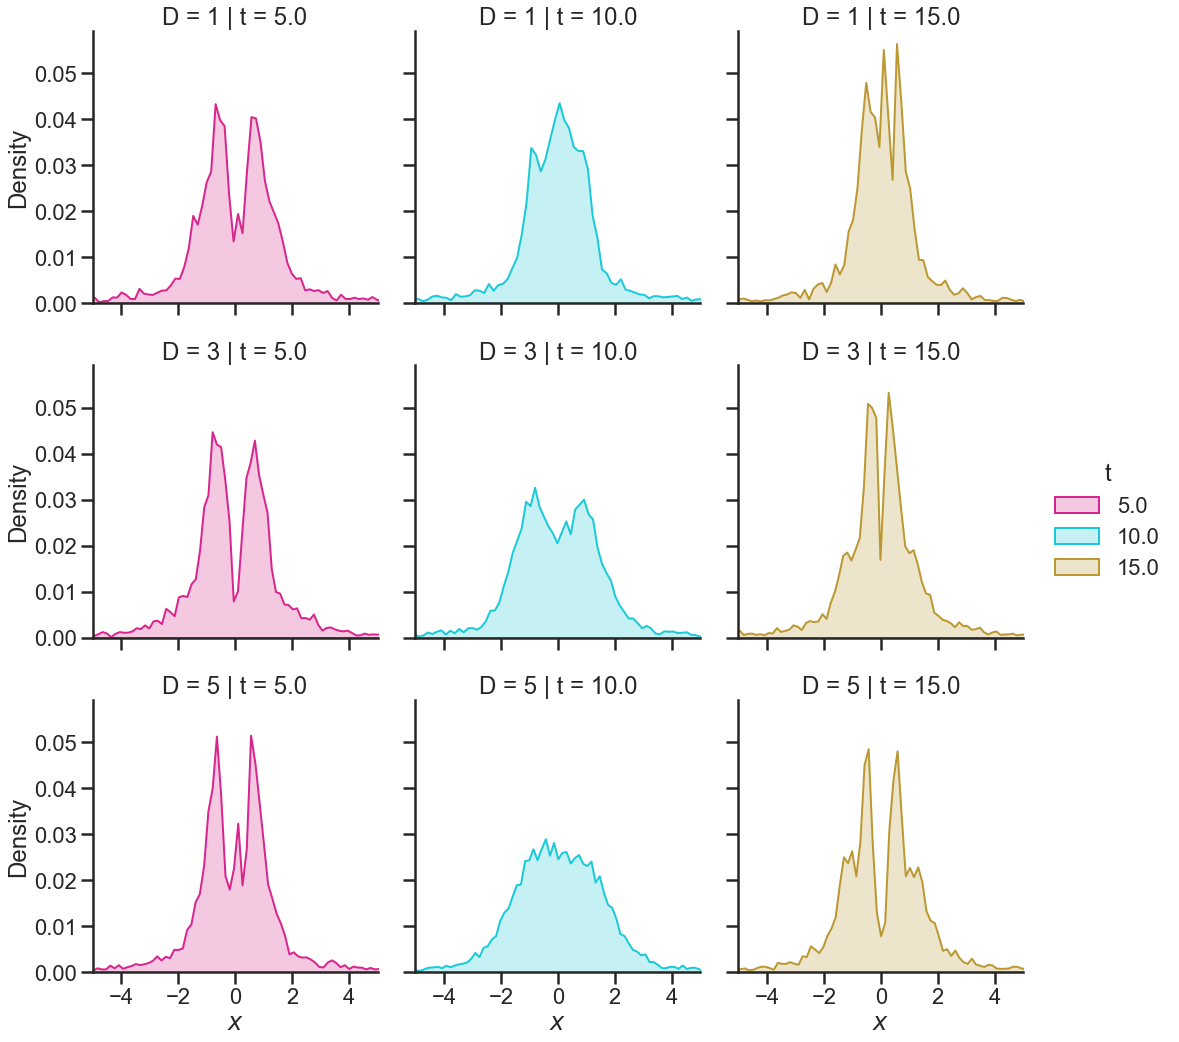

In [49]:
with sns.plotting_context("poster", rc={"figure.dpi": 400}):
    g = sns.displot(
        data=x_df[(~x_df["seed"].isin([]))],
        x=OPINION_SYMBOL,
        # hue="sample_method", hue_order=["full"],
        hue="t", palette=[PRE_RDN_COLOR, POST_RDN_COLOR, POST_RECOVERY_COLOR],
        # hue="seed",
        col="t",
        row="D",
        kind="kde",
        fill=True,
        bw_adjust=0.1,
    )
    g.set(xlim=(-5, 5))


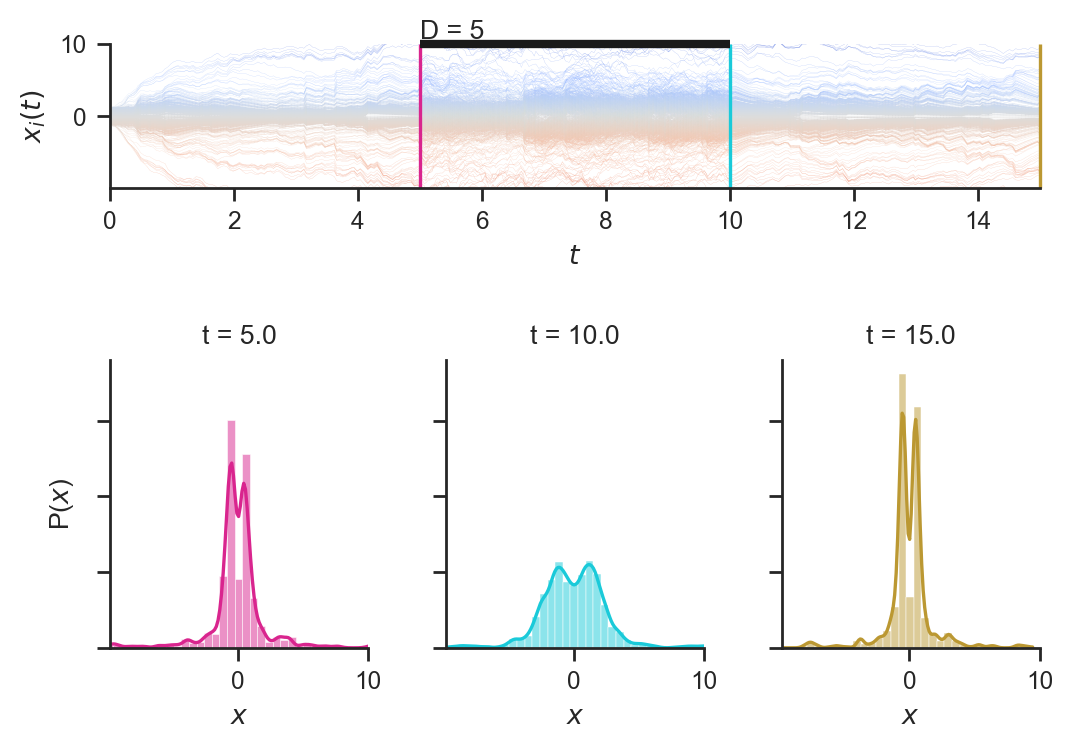

In [23]:
from opdynamics.visualise.vissimulation import show_periodic_noise

nsn = nsns[-1]

D = max(_D for t, _D in nsn._D_hist)
with sns.plotting_context("paper"):
    with plt.rc_context({"figure.dpi": 200}):
        show_periodic_noise(
        nsn,
        noise_start,
        noise_length,
        recovery,
        interval,
        num,
        D,
        t_window=0.0,
    )


In [ ]:
%matplotlib inline
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from opdynamics.utils.plot_utils import colorbar_inset, colorline, get_time_point_idx
vis = VisSocialNetwork(nsn)

kwargs = {}

with sns.plotting_context("paper"):
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = (6, 3)

    fig, axes = plt.subplots(ncols=2, sharex=False, sharey=True, 
                             gridspec_kw={"width_ratios": [1, 0.5]})

    t_point = float(noise_start)

    t_idx = get_time_point_idx(nsn.result.t, t_point)
    t_idx_end = get_time_point_idx(nsn.result.t, t_point+noise_length)

    pre_noise_opinions_unsorted = nsn.result.y[:, t_idx]
    post_noise_opinions_unsorted = nsn.result.y[:, t_idx_end]

    x_idx = np.argsort(pre_noise_opinions_unsorted)

    pre_noise_opinions = pre_noise_opinions_unsorted[x_idx]
    post_noise_opinions = nsn.result.y[x_idx, t_idx_end]
    change_in_opinions = post_noise_opinions - pre_noise_opinions
    change_in_opinions_overall = np.sort(post_noise_opinions) - pre_noise_opinions

    cmap_pre = sns.light_palette(PRE_RDN_COLOR, n_colors=1, as_cmap=True)
    cmap_post = sns.light_palette(POST_RDN_COLOR, n_colors=1, as_cmap=True)
    # green and purple diverging colormap (white in middle)
    cmap_change = sns.diverging_palette(145, 300, s=-60, as_cmap=True)
    cmap_change = sns.light_palette(DELTA_RDN_COLOR, as_cmap=True)
    
    vmax = np.max(np.abs(change_in_opinions))
    vmin = -vmax
    v = vis._get_equal_opinion_limits()
    
    sm_change = ScalarMappable(norm=Normalize(vmin, vmax), cmap=cmap_change)
    
    vis.show_agent_opinions(sort=x_idx, t=t_point, title=False, ax=axes[0],
                            colorbar=False, show_middle=False,
                            alpha=0.3,
                            cmap=cmap_pre,
                           )
    vis.show_agent_opinions(sort=x_idx, t=t_point+noise_length, title=False, ax=axes[0], 
                            alpha=0.7, colorbar=False, show_middle=False,
                            cmap=cmap_post
                           )

    axes[1].barh(
        np.arange(nsn.N),
        change_in_opinions,
        color=sm_change.to_rgba(np.abs(change_in_opinions)),
        edgecolor="None",
        linewidth=0,  # remove bar borders
        height=1,  # per agent
        alpha=0.8,
        **kwargs
    )
#     cbar = colorbar_inset(sm_change, "outer bottom", size="5%", pad=0.01, ax=axes[1])
    axes[0].set_xlim(-6,6)
    axes[1].set_xlim(-2,2)
    
#     axes[1].set_ylim(0, nsn.N)
    # axes[0].set_xscale("symlog")
    # axes[1].set_xscale("symlog")
    
    for ax in axes:
        sns.despine(ax=ax, offset=5)
#         ax.tick_params(axis="x", bottom=False, labelbottom=False)
    axes[1].set_xlabel(math_fix(f"$\Delta ${OPINION_SYMBOL}"))
    axes[0].legend([Line2D([],[], color=PRE_RDN_COLOR, alpha=0.3), Line2D([],[], color=POST_RDN_COLOR, alpha=0.7)],
                   ["Pre RDN", "Post RDN"], 
                  frameon=False)
    plt.savefig("output/dx.svg")

In [ ]:
from matplotlib.colors import SymLogNorm
plt.barh(
    nsn.agent_idxs,
    np.sort(pre_noise_opinions_unsorted),
    edgecolor="None",
    linewidth=0,  # remove bar borders
    height=1,  # per agent
    alpha=0.5,
    color=PRE_RDN_COLOR,
)
plt.barh(
    nsn.agent_idxs,
    np.sort(post_noise_opinions_unsorted),
    edgecolor="None",
    linewidth=0,  # remove bar borders
    height=1,  # per agent
    alpha=0.5,
    color=POST_RDN_COLOR,
)
plt.figure()

change_in_opinions = post_noise_opinions_unsorted - pre_noise_opinions_unsorted
change_in_opinions_sorted = np.sort(post_noise_opinions_unsorted)-np.sort(pre_noise_opinions_unsorted)
cmap_change = sns.diverging_palette(145, 300, s=-60, as_cmap=True)
vmax = np.max(np.abs(change_in_opinions))
vmin = -vmax
v = vis._get_equal_opinion_limits()

mask = ((change_in_opinions_sorted>0) & (np.sort(pre_noise_opinions_unsorted)>0)) | ((change_in_opinions_sorted<0) & (np.sort(pre_noise_opinions_unsorted)<0))

sm_change = ScalarMappable(norm=SymLogNorm(linthresh=0.1, vmin=vmin, vmax=vmax), cmap=cmap_change)

direction = sm_change.to_rgba(change_in_opinions_sorted)

plt.barh(
    np.array(nsn.agent_idxs)[mask],
    change_in_opinions_sorted[mask],
    edgecolor="None",
    linewidth=0,  # remove bar borders
    height=1,  # per agent
    alpha=0.5,
    color='grey'
)
plt.barh(
    np.array(nsn.agent_idxs)[~mask],
    change_in_opinions_sorted[~mask],
    edgecolor="None",
    linewidth=0,  # remove bar borders
    height=1,  # per agent
    alpha=0.5,
    color=DELTA_RDN_COLOR
)

In [ ]:
fig, ax_joint, ax_marg_x, ax_marg_y = vis.show_nearest_neighbour(t=noise_start, color=PRE_RDN_COLOR)
ax_joint.set_xlim(-5, 5)
ax_joint.set_ylim(-5, 5)


In [ ]:
fig, ax_joint, ax_marg_x, ax_marg_y = vis.show_nearest_neighbour(t=noise_start+noise_length, color=POST_RDN_COLOR)
ax_joint.set_xlim(-5, 5)
ax_joint.set_ylim(-5, 5)

In [ ]:
# get network properties

print("[0; noise start]")
G_start, df_start = nsn.get_network_agents((0.0, noise_start))
_, df_start_conn = nsn.get_network_connections((0.0, noise_start))
df_start["RDN"] = "Pre RDN"
df_start_conn["RDN"] = "Pre RDN"

print("[noise start; noise end]")
G_noise, df_noise = nsn.get_network_agents((noise_start, noise_start + noise_length))
_, df_noise_conn = nsn.get_network_connections(
    (noise_start, noise_start + noise_length)
)
df_noise["RDN"] = "Post RDN"
df_noise_conn["RDN"] = "Post RDN"

print("[0, noise end]")
G_full_noise, df_full_noise = nsn.get_network_agents((0.0, noise_start + noise_length))
_, df_full_noise_conn = nsn.get_network_connections((0.0, noise_start + noise_length))

df_degree = pd.concat([df_start, df_noise], ignore_index=True)
df_conn = pd.concat([df_start_conn, df_noise_conn], ignore_index=True)

df_degree


In [ ]:
rdn_name = "Network state"
density_label = math_fix(f"P({OPINION_SYMBOL},{IN_DEGREE_SYMBOL})")

with sns.plotting_context("paper"):
    plt.rcParams["legend.frameon"] = False

    fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

    inset_ax = ax.inset_axes(bounds=[0.7, 0.3, 0.3, 0.3])

    sns.histplot(
        df_degree.rename(columns={"RDN": rdn_name}),
        x="in_degree",
        hue=rdn_name,
        palette=[PRE_RDN_COLOR, POST_RDN_COLOR],
        log_scale=True,
        stat="probability",
        ax=ax,
    )

    ax.set(
        xlabel=f"In degree for agent $i$ \n " + math_fix(f"[{IN_DEGREE_SYMBOL}]"),
        ylabel=math_fix(f"P({IN_DEGREE_SYMBOL})"),
    )

    sns.kdeplot(
        data=df_degree.rename(columns={"RDN": rdn_name}),
        x="opinion",
        y="in_degree",
        hue=rdn_name,
        palette=[PRE_RDN_COLOR, POST_RDN_COLOR],
        alpha=0.5,
        levels=8,
        log_scale=(False, True),
        fill=True,
        legend=False,
        ax=inset_ax,
    )

    inset_ax.set(
        xlim=(-5, 5),
        ylim=(50, 5000),
        ylabel=IN_DEGREE_SYMBOL,
        xlabel=OPINION_SYMBOL,
        title=density_label,
    )
    plt.savefig("output/in_degree.svg")


In [ ]:
vis = VisSocialNetwork(nsn)

kwargs = {"map": "heatmap", "sort": True, "cmap": "viridis"}

# vis.show_adjacency_matrix(title="Pre RDN", t=(0.0, noise_start), **kwargs)
# vis.show_adjacency_matrix(title="Post RDN", t=(noise_start, noise_start+noise_length), **kwargs)
vis.show_adjacency_matrix(title="Pre RDN", t=(noise_start - 1.0, noise_start), **kwargs)
vis.show_adjacency_matrix(
    title="Post RDN",
    t=(noise_start + noise_length - 1.0, noise_start + noise_length),
    **kwargs
)


In [ ]:
from matplotlib.colors import LogNorm, Normalize, SymLogNorm
from opdynamics.visualise.dense import show_matrix
from opdynamics.utils.plot_utils import get_time_point_idx

window_size = noise_start / 2

t_idx_pre, opinions_pre_rdn_all = nsn.opinions_at_t(
    (noise_start - window_size, noise_start), flatten=False
)
t_idx_post, opinions_post_rdn_all = nsn.opinions_at_t(
    ((noise_start + noise_length - window_size), noise_start + noise_length),
    flatten=False,
)

acc_adj_mat_pre_rdn = nsn.adj_mat.accumulate(t_idx_pre)
acc_adj_mat_post_rdn = nsn.adj_mat.accumulate(t_idx_post)

opinions_pre_rdn = opinions_pre_rdn_all[:, -1]
opinions_post_rdn = opinions_post_rdn_all[:, -1]

agent_mat_pre = pd.DataFrame(
    acc_adj_mat_pre_rdn,
    columns=pd.Index(nsn.agent_idxs, name="i"),
    index=pd.Index(nsn.agent_idxs, name="j"),
)
agent_mat_post = pd.DataFrame(
    acc_adj_mat_post_rdn,
    columns=pd.Index(nsn.agent_idxs, name="i"),
    index=pd.Index(nsn.agent_idxs, name="j"),
)

with sns.plotting_context("paper"):

    fig, axes = plt.subplots(
        nrows=3, sharex=True, sharey=True, figsize=(3, 4.5), dpi=400
    )
    fig.subplots_adjust(left=0.3, right=0.7, hspace=0.1)
    cbar_kws = dict(
        vmin=1, vmax=max(agent_mat_pre.values.max(), agent_mat_post.values.max())
    )

    fig, ax = show_matrix(
        agent_mat_pre,
        "Pre RDN interactions",
        map="mesh",
        sort=True,
        #                       cmap="viridis",
        cmap=sns.light_palette(PRE_RDN_COLOR, as_cmap=True),
        title="",
        rasterized=True,
        ax=axes[0],
        **cbar_kws
    )
    axes[0].set_xlabel("")
    # access computed sorted dataframe (not present if sort=False)
    df_sorted_mat = show_matrix.sorted_mat

    # set to same index/columns as pre-rdn sorted matrix
    agent_mat_post = agent_mat_post.loc[df_sorted_mat.index, df_sorted_mat.columns]
    fig, ax = show_matrix(
        agent_mat_post,
        "Post RDN interactions",
        map="mesh",
        sort=False,
        #                       cmap="viridis",
        cmap=sns.light_palette(POST_RDN_COLOR, as_cmap=True),
        title="",
        rasterized=True,
        ax=axes[1],
        zorder=-10,
        **cbar_kws
    )

    delta_mat = agent_mat_post - agent_mat_pre
    delta_mat_abs = np.abs(delta_mat)
    fig, ax = show_matrix(
        delta_mat,
        "Delta interactions",
        map="mesh",
        sort=False,
        cmap="icefire",
        #   cmap=sns.light_palette(DELTA_RDN_COLOR, as_cmap=True),
        title="",
        rasterized=True,
        ax=axes[-1],
        #  norm=LogNorm(), vmin=1, vmax=delta_mat_abs.values.max(),
        norm=SymLogNorm(
            1, vmin=-delta_mat_abs.values.max(), vmax=delta_mat_abs.values.max()
        ),
    )

    #     for ax in axes:
    #         ax.set_rasterized(True)
    #     fig.tight_layout()
    fig.savefig("output/interactions.svg")
# fig, ax = show_matrix(agent_mat_pre, "Number of interactions", map="heatmap", sort=True, cmap="viridis", title="Pre RDN")
# fig, ax = show_matrix(agent_mat_post, "Number of interactions", map="heatmap", sort=True, cmap="viridis", title="Post RDN")


In [ ]:
columns = ["opinion", "in_degree"]
df_change = df_noise[columns] - df_start[columns]
df_change.columns = [
    math_fix(f"$\Delta {OPINION_SYMBOL}$"),
    math_fix(f"$\Delta {IN_DEGREE_SYMBOL}$"),
]
df_change[
    [
        math_fix(f"|$\Delta {OPINION_SYMBOL}$|"),
        math_fix(f"|$\Delta$ {IN_DEGREE_SYMBOL}|"),
    ]
] = df_change.abs()
df_change

In [ ]:
plot_scatter = True  # @param {type:"boolean"}
absolute_y = False  # @param {type:"boolean"}

with sns.plotting_context("paper"):
    plt.rcParams["figure.dpi"] = 200

    fig, axes = plt.subplots(
        ncols=2,
        figsize=(3.75, 2.25),
        gridspec_kw={"width_ratios": [1, 0.5]},
        sharey=True,
    )

    sns.kdeplot(
        data=df_change,
        x=df_change.columns[0],
        y=df_change.columns[1],
        color=DELTA_RDN_COLOR,
        fill=True,
        ax=axes[0],
    )
    if plot_scatter:
        sns.scatterplot(
            data=df_change,
            x=df_change.columns[0],
            y=df_change.columns[1],
            color="grey",
            alpha=0.5,
            ec="None",
            s=1,
            ax=axes[0],
        )

    # absolutes

    sns.kdeplot(
        data=df_change,
        x=df_change.columns[2],
        y=df_change.columns[1 + 2 * int(absolute_y)],
        color=DELTA_RDN_COLOR,
        ax=axes[1],
        fill=True,
    )
    if plot_scatter:
        #     sns.scatterplot(data=df_change, x=df_change.columns[2], y=df_change.columns[1+2*int(absolute_y)],
        #                     color="grey",
        #                     alpha=0.5, sn="None", s=1,
        #                     ax=axes[1]
        #                    )
        sns.regplot(
            data=df_change,
            x=df_change.columns[2],
            y=df_change.columns[1 + 2 * int(absolute_y)],
            color="grey",
            scatter_kws=dict(
                alpha=0.5,
                ec="None",
                s=1,
            ),
            line_kws=dict(
                alpha=0.8,
                lw=2,
            ),
            ax=axes[1],
        )

    axes[0].set(
        xlim=(-3, 3), ylim=(axes[0].get_ylim()[0] / 1.5, axes[0].get_ylim()[1] / 1.5)
    )
    axes[1].set(xlim=(0, 2))
    plt.savefig("output/change_v_indegree.svg")

## Range


In [ ]:
# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
from opdynamics.utils.cache import get_cache_dir, set_cache_dir

old_dir, new_dir = set_cache_dir(os.path.join("/content", ".cache", "delayed_noise"))

noise_start = 10.0
noise_length = 10.0
recovery = 10.0
num = 1
interval = 0
seeds = [1337, 10725983, 7988657, 1572039, 15379820]
kwargs = dict(
    N=1000,
    m=10,
    activity_distribution=negpowerlaw,
    epsilon=1e-2,
    gamma=2.1,
    dt=0.01,
    K=3,
    beta=3,
    alpha=3,
    r=0.5,
    update_conn=True,
    cls=SampleChamber,
    method="RK45",
    D=5,
    sample_size=30,
    sample_method="full",
    noise_start=noise_start,
    noise_length=noise_length,
    recovery=recovery,
    interval=interval,
    num=num,
)
with sns.plotting_context("paper"):
    plt.rcParams["figure.dpi"] = 200
    plt.rcParams["figure.figsize"] = (3.375, 3)
    nec_list = Simulation.run_product(
        range_parameters={
            "D": {"range": [1, 3, 5]},
            "sample_size": {"range": [1, 30, 50]},
            "sample_method": {"range": ["full", "subsample", "simple"]},
            "update_conn": {"range": [True]},
            "seed": {"range": seeds},
        },
        cache="all",
        cache_sim=False,
        parallel=True,
        plot_opinion=True,
        **kwargs
    )

old_dir, new_dir = set_cache_dir(old_dir)
logging.getLogger().setLevel(logging_level)

nec_dict = {}
for nsn in nec_list:
    key = (tuple(nsn._D_hist), nsn._sample_method[0], nsn._sample_size)
    nec_dict.setdefault(key, [])
    nec_dict[key].append(nsn)

In [ ]:
from tqdm.contrib import tenumerate
from matplotlib.cbook import flatten

num_seeds = len(seeds)

with sns.plotting_context("paper"):
    plt.rcParams["axes.titlesize"] = "xx-small"
    plot_colors = sns.color_palette("Set1", n_colors=num_seeds)
    fig, axs = plt.subplots(
        len(nec_dict.keys()),
        num_seeds + 1,
        figsize=(5, 15),
        sharex="col",
        sharey="all",
    )
    fig.subplots_adjust(hspace=0.3)
    sns.despine(fig, bottom=True)
    for i, key in tenumerate(sorted(nec_dict.keys())):
        print(key)
        for j, nsn in tenumerate(nec_dict[key]):
            _visec = VisSocialNetwork(nsn)
            title_key = f"{key[0][1][1]}, {key[1]}, {key[2]}"
            _visec.show_opinions(
                "line", subsample=50, title=title_key, fig=fig, ax=axs[i, j]
            )
            _visec.show_opinions_distribution(
                t=20,
                vertical=True,
                color=plot_colors[j],
                ax=axs[i, -1],
                title="",
                element="poly",
                stat="density",
            )
            axs[i, j].axvline(20, ymin=-10, ymax=10, lw=0.5, c=plot_colors[j])
            axs[i, j].axvline(10, ymin=-10, ymax=10, ls="--", lw=0.5, c=plot_colors[j])
    for ax in flatten(axs[:, 1:]):
        ax.set_ylabel("")
    for ax in flatten(axs[:-1, :]):
        ax.set_xlabel("")

    axs[0, 0].set_ylim(-5, 5)
print("showing")


# Compare sample methods


In [ ]:
from opdynamics.dynamics.opinions import clt_methods

logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.INFO)


# polar opinions
N = 1000  # @param {type:"integer"}
m = 10  # @param {type:"integer"}
α = 3  # @param {type:"slider", min:0, max:5, step:0.5}
K = 3  # @param {type:"slider", min:0, max:5, step:0.5}
ε = 0.01  # @param {type:"slider", min:0.005, max:0.05, step:0.005}
Υ = 2.1  # @param {type:"slider", min:0, max:3, step:0.1}
β = 3  # @param {type:"slider", min:0, max:5, step:0.5}
r = 0.5  # @param {type:"slider", min:0, max:1, step:0.1}
activity_distribution = negpowerlaw
dt = 0.01
T = 5  # @param {type:"slider", min:0, max:10, step:1}
# Nudge arguments
D = 1  # @param {type:"slider", min:0, max:20, step:0.5}
sample_size = 1  # @param {type:"slider", min:1, max:100, step:1}
seed_idx = -1  # @param {type:"slider", min:-1, max:20, step:1}
integration_method = "RK45"  # @param ["Euler", "RK45"]

clt_method_names = [k for k in clt_methods.keys() if k is not None]

# custom sample methods
from opdynamics.metrics.opinions import sample_means


def custom_sample_basic2(sn, y: np.ndarray, n: int, num_samples: int):
    """no sqrt(n)"""
    sn._sample_means = sample_means(y, n, num_samples=num_samples, rng=sn.rn) - np.mean(
        y
    )


def custom_sample_n1v1000(sn, y: np.ndarray, n: int, num_samples: int):
    sn._sample_means = sample_means(
        y, 1, num_samples=num_samples, rng=sn.rn
    ) - sample_means(y, 1000, num_samples=num_samples, rng=sn.rn)


def custom_sample_n1v100(sn, y: np.ndarray, n: int, num_samples: int):
    sn._sample_means = sample_means(
        y, 1, num_samples=num_samples, rng=sn.rn
    ) - sample_means(y, 100, num_samples=num_samples, rng=sn.rn)


def custom_sample_n1vmean(sn, y: np.ndarray, n: int, num_samples: int):
    sn._sample_means = sample_means(y, 1, num_samples=num_samples, rng=sn.rn) - np.mean(
        y
    )


def custom_sample_n1v1(sn, y: np.ndarray, n: int, num_samples: int):
    sn._sample_means = sample_means(
        y, 1, num_samples=num_samples, rng=sn.rn
    ) - sample_means(y, 1, num_samples=num_samples, rng=sn.rn)


def custom_sample_n1v10(sn, y: np.ndarray, n: int, num_samples: int):
    sn._sample_means = sample_means(
        y, 1, num_samples=num_samples, rng=sn.rn
    ) - sample_means(y, 10, num_samples=num_samples, rng=sn.rn)


def custom_sample_n1v0(sn, y: np.ndarray, n: int, num_samples: int):
    sn._sample_means = sample_means(y, 1, num_samples=num_samples, rng=sn.rn)


def custom_sample_n0v1(sn, y: np.ndarray, n: int, num_samples: int):
    sn._sample_means = -sample_means(y, 1, num_samples=num_samples, rng=sn.rn)


def custom_sample_n0(sn, y: np.ndarray, n: int, num_samples: int):
    sn._sample_means = 0


clt_method_names += [
    custom_sample_basic2,
    custom_sample_n1v1000,
    custom_sample_n1v100,
    custom_sample_n1v10,
    custom_sample_n1v1,
    custom_sample_n1vmean,
    custom_sample_n1v0,
    custom_sample_n0v1,
    custom_sample_n0,
]

# fig, ax = plt.subplots(len(clt_method_names), 1,
# #                        gridspec_kw=dict(width_ratios=[1,0.1]),
#                        squeeze=False,
#                        sharey='row',
#                        sharex='col',
#                        figsize=(4, 8),
#                        dpi=200)
# fig.subplots_adjust(wspace=0.1, hspace=0.5)
# palette = sns.color_palette("husl", n_colors=len(clt_method_names))

seeds = np.geomspace(1, 100000, num=20, dtype=int)

if seed_idx >= 0:
    seeds = [seeds[seed_idx]]

file_name = f"{get_cache_dir('sample_methods')}/df.h5"

# the efficient HDF format is used for saving and loading DataFrames.
with pd.HDFStore(file_name) as hdf:
    # get keys from the store to know how many simulations have already been saved
    seeds_completed = hdf.keys()
    #     print(seeds_completed)
    for i, sample_method in enumerate(clt_method_names):
        for seed in seeds:
            sc = Simulation.run_params(
                cls=SampleChamber,
                N=N,
                m=m,
                K=K,
                alpha=α,
                beta=β,
                activity=activity_distribution,
                gamma=Υ,
                epsilon=ε,
                r=r,
                dt=dt,
                T=T,
                D=D,
                sample_size=sample_size,
                sample_method=sample_method,
                method=integration_method,
                plot_opinion=False,
                seed=seed,
                cache=True,
            )
            title = (
                sample_method if type(sample_method) is str else sample_method.__name__
            )
            key = f"/{title}_{seed}_{hash(str(sc))}"
            if key in seeds_completed:
                continue
            temp_df = pd.DataFrame({OPINION_SYMBOL: sc.opinions})
            temp_df["Method"] = title
            hdf.append(f"{title}_{seed}_{hash(str(sc))}", temp_df)
#         meth_df = meth_df.append(temp_df, ignore_index=True)

#         vis = VisSocialNetwork(sc)
#     #     vis.show_opinions(color_code='line', ax=ax[i, 0],
#     #                       title=sample_method if type(sample_method) is str else sample_method.__name__)
#         vis.show_opinions_distribution(ax=ax[i, 0], vertical=False,
#                                        kde_kws=dict(bw_adjust=0.1), color=palette[i],
#                                        title=title)
#         if i<len(clt_method_names):
#             ax[i,0].set_xlabel("")
#     #         ax[i,1].set_xlabel("")
#         ax[i,0].set_xlim(-5,5)
# collect all data into a dataframe
with pd.HDFStore(file_name) as hdf:
    meth_df = pd.concat([hdf.get(key) for key in hdf.keys()])

logging.getLogger().setLevel(logging_level)


In [ ]:
sns.palplot(sns.blend_palette(["#000", "#F6911E", "#919395"], 11))

In [ ]:
str_names = [
    sample_method if type(sample_method) is str else sample_method.__name__
    for sample_method in clt_method_names
]
str_names = [
    "full",
    #  'outer_sigmoid',
    #  'inner_sigmoid',
    #  'subsample',
    "custom_sample_basic2",
    "custom_sample_n1v1000",
    "custom_sample_n1v100",
    "custom_sample_n1v10",
    "custom_sample_n1v1",
    #  'custom_sample_n1vmean',
    "custom_sample_n1v0",
    "custom_sample_n0v1",
    "custom_sample_n0",
]
str_names

In [ ]:
label_map = {
    "full": "$\\sqrt {n}\\left(\\langle X_{n} \\rangle-\\langle X \\rangle \\right)$",
    "custom_sample_basic2": "$\\langle X_{n} \\rangle-\\langle X \\rangle$",
    "outer_sigmoid": "$\\tanh{(\\sqrt{n} \\cdot \\left(\\langle X_{n} \\rangle-\\langle X \\rangle \\right)})$",
    "inner_sigmoid": "$\\sqrt{n} \\cdot \\tanh{\\left(\\langle X_{n} \\rangle -\\langle X \\rangle \\right)}$",
    "subsample": "$X_1 - \\langle X_{10}$",
    "custom_sample_n1v1000": "$X_1 - \\langle X_{N} \\rangle$",
    "custom_sample_n1v100": "$X_1 - \\langle X_{100} \\rangle$",
    "custom_sample_n1v10": "$X_1 - \\langle X_{10} \\rangle$",
    "custom_sample_n1v1": "$X_1 - X'_1$",
    "custom_sample_n1vmean": "$X_1 - \\langle X \\rangle$",
    "custom_sample_n1v0": "$X_1$",
    "custom_sample_n0v1": "$-X_1$",
    "custom_sample_n0": "$0$",
}

In [ ]:
with sns.plotting_context("paper"):
    plt.rcParams["axes.facecolor"] = "None"
    pal = sns.cubehelix_palette(len(clt_method_names), rot=-0.25, light=0.7)
    g = sns.FacetGrid(
        meth_df,
        row="Method",
        row_order=str_names,
        hue="Method",
        hue_order=str_names,
        aspect=7,
        height=0.3,
        palette=pal,
    )

    bw_adjust = 0.5
    # Draw the densities in a few steps
    g.map(
        sns.kdeplot,
        OPINION_SYMBOL,
        bw_adjust=bw_adjust,
        clip_on=False,
        fill=True,
        alpha=1,
        linewidth=1.5,
    )
    g.map(
        sns.kdeplot, OPINION_SYMBOL, clip_on=False, color="w", lw=2, bw_adjust=bw_adjust
    )
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(
            0,
            0.2,
            label_map[label],
            fontweight="bold",
            color=color,
            ha="right",
            va="center",
            transform=ax.transAxes,
        )

    g.map(label, OPINION_SYMBOL)
    g.fig.subplots_adjust(hspace=-0.25)
    g.set_titles("")
    g.set(yticks=[], xlim=(-5, 5))
    g.despine(bottom=True, left=True)
    #     g.axes.flat[-1].set_xticks(range(-4, 6,2))
    g.savefig("output/sample_methods.svg")

# Other plot types


## $K-\alpha$ phase space

- $K \in [0,4]$
- $\alpha \in [0,4]$

with

- $beta = 0.5$
- $r = 0.5$


In [ ]:
import os
import gc

eclogger.setLevel(logging.DEBUG)

beta = 0.5
r = 0.5

# how many simulations to run
num_states = 8
start = 0
stop = 4
K_range = np.round(np.linspace(start, stop, num_states), 2)
alpha_range = np.round(np.linspace(start, stop, num_states), 2)


# where to save the file
file_name = ".cache/K-alpha-phase.h5"

# the efficient HDF format is used for saving and loading DataFrames.
if os.path.exists(file_name):
    df = pd.read_hdf(file_name)
else:
    df = pd.DataFrame(index=K_range, columns=alpha_range, dtype=float)
    for K, alpha in tqdm(list(itertools.product(K_range, alpha_range))):
        sn = Simulation.run_params(
            SocialNetwork,
            N=N,
            m=m,
            K=K,
            alpha=alpha,
            beta=beta,
            activity=activity_distribution,
            epsilon=epsilon,
            gamma=gamma,
            r=r,
            dt=dt,
            T=T,
            store_all=False,
            cache=False,  # don't cache full time of sim
            plot_opinion=False,
        )
        t, mu = sn.get_mean_opinion(-1)
        df.loc[K, alpha] = mu
        # clear some memory
        del sn
        gc.collect()
    df.to_hdf(file_name, key="df")

show_K_alpha_phase(df)
fig = plt.gcf()
fig.savefig("output/k-alpha-phase.svg")

## Agent opinions at $t$


In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
fig.subplots_adjust(hspace=0.3)
vis.show_agent_opinions(direction=True, sort=True, ax=ax[0])
vis.show_opinions_distribution(ax=ax[1], kde_kws=dict(fill=True))
ax[1].set_xticklabels(ax[1].get_xticks())
sns.despine()

In [ ]:
fig, ax = plt.subplots(1, 2, gridspec_kw=dict(width_ratios=[10, 1]))
fig.subplots_adjust(wspace=0.1)
vis.show_opinions(ax=ax[0], title="Polarised")
vis.show_opinions_distribution(
    ax=ax[1], kde_kws=dict(fill=False, bw_adjust=0.15), vertical=True
)
sns.despine()
sns.despine(ax=ax[1], left=True)
ax[1].set_ylabel("")
ax[1].tick_params(axis="y", left=False, labelleft=False)


In [ ]:
fig, ax = plt.subplots(1, 2, gridspec_kw=dict(width_ratios=[10, 1]))
fig.subplots_adjust(wspace=0.1)
vis.show_opinions(ax=ax[0], title="Polarised")
vis.show_opinions_distribution(
    ax=ax[1], kde_kws=dict(fill=False, bw_adjust=0.15), vertical=True
)
sns.despine()
sns.despine(ax=ax[1], left=True)
ax[1].set_ylabel("")
ax[1].tick_params(axis="y", left=False, labelleft=False)
